In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive/Tesi Notebooks

/gdrive/My Drive/Tesi Notebooks


In [6]:
!pip install -q flwr['simulation'] tensorflow===2.13.1

In [7]:
!pip install codecarbon

In [ ]:
!pip install --force-reinstall gpustat

  Using cached gpustat-1.1.1-py3-none-any.whl
  Using cached nvidia_ml_py-12.535.108-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 2.8 MB/s eta 0:00:00
  Using cached blessed-1.20.0-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.8
    Uninstalling wcwidth-0.2.8:
      Successfully uninstalled wcwidth-0.2.8
  Attempting uninstall: nvidia-ml-py
    Found existing installation: nvidia-ml-py 12.535.108
    Uninstalling nvidia-ml-py-12.535.108:
      Successfully uninstalled nvidia-ml-py-12.535.108
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: blessed
    Found existing installation: blessed 1.20.0
    Uninstalling blessed-1.

In [8]:
#Data quality libraries
from imblearn.under_sampling import RandomUnderSampler

#import codecarbon to evaluate energy consumption
from codecarbon import OfflineEmissionsTracker

#import flwr libraries
import flwr as fl
from flwr.common import (
    Status,
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    Metrics,
)

from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth


from flwr.common.logger import log
from logging import WARNING
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union

import tensorflow as tf
import numpy as np
import os
import random
import json
import datetime
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
import warnings
import logging
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.13.1


In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# StarLightCurves Dataset

In [10]:
train_data = np.loadtxt(f"./StarLightCurves/StarLightCurves_TRAIN.txt")
test_data = np.loadtxt(f"./StarLightCurves/StarLightCurves_TEST.txt")

#np.random.shuffle(train_data)
#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

#Take the last 1000 samples of x_train for the validation step
X_val = X_train[-1000:]
y_val = y_train[-1000:]

X_train = X_train[:-1000]
y_train = y_train[:-1000]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7236, 1024, 1), (7236,), (1000, 1024, 1), (1000,), (1000, 1024, 1), (1000,))

## Distribution StarLight Curves Dataset

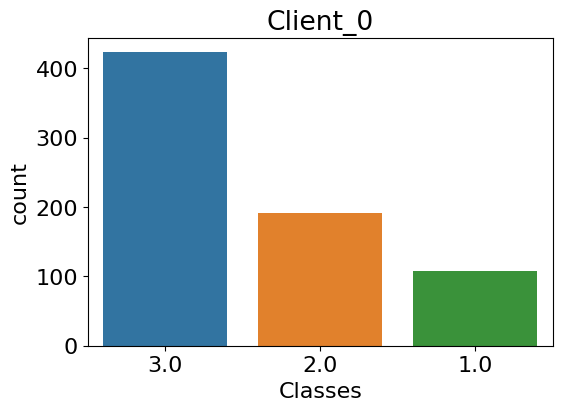

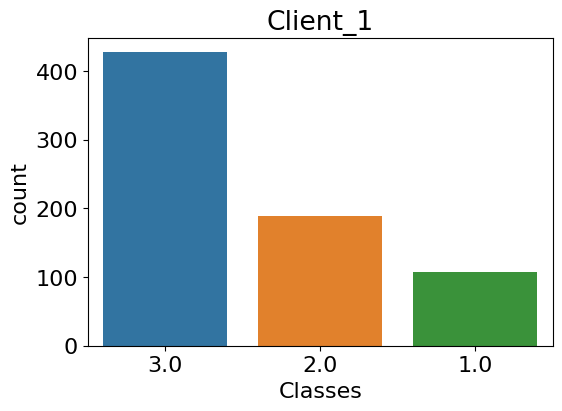

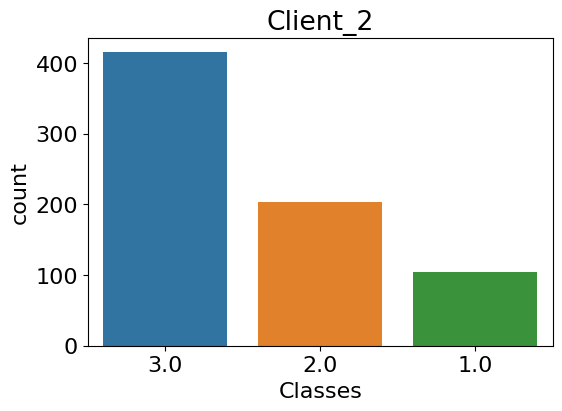

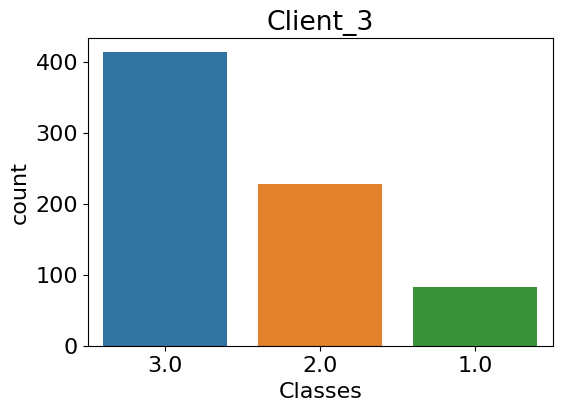

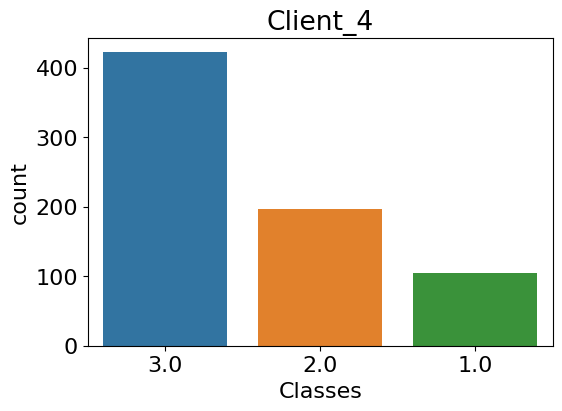

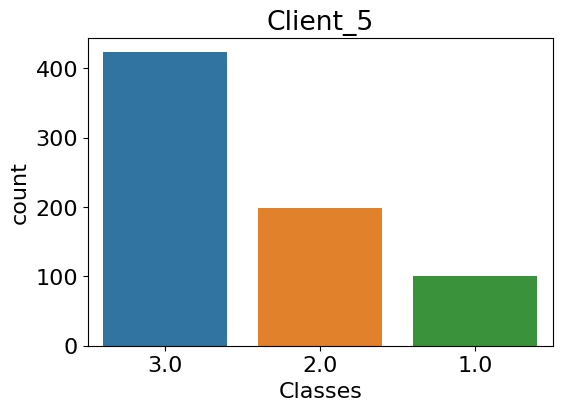

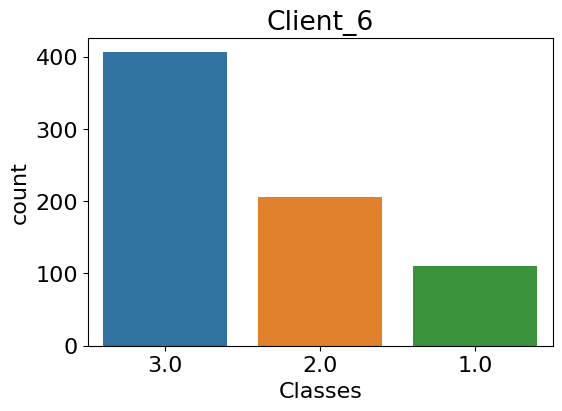

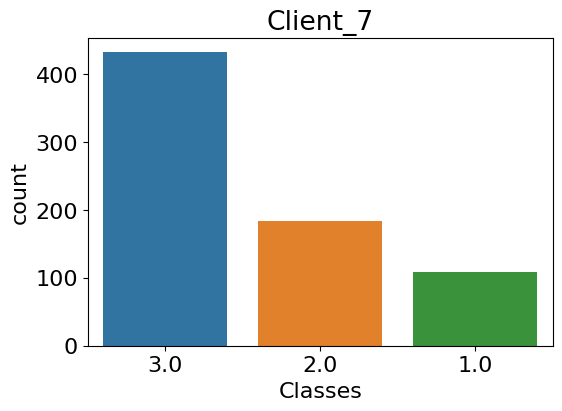

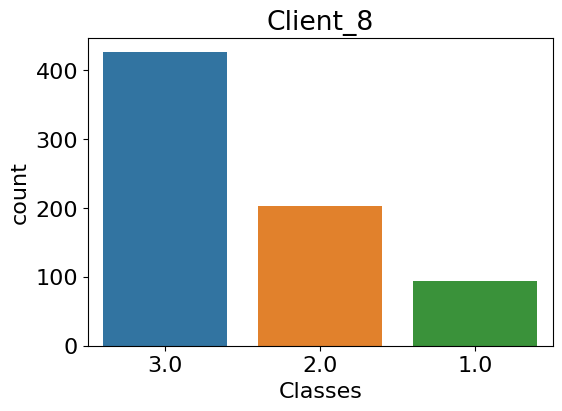

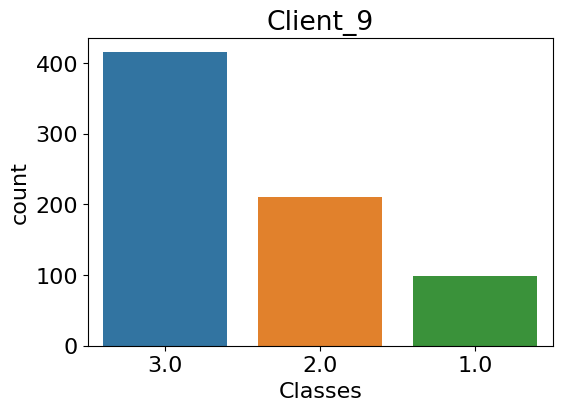

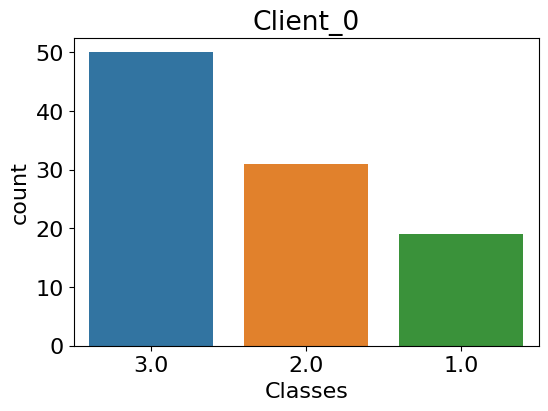

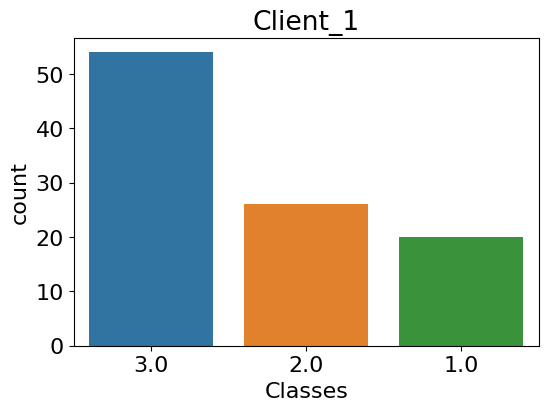

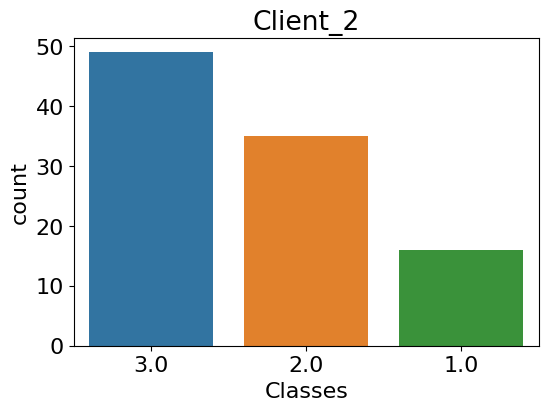

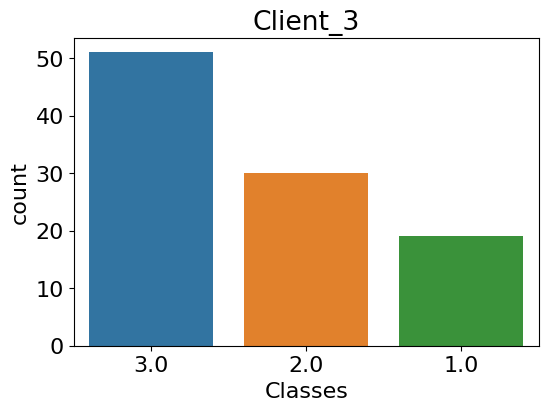

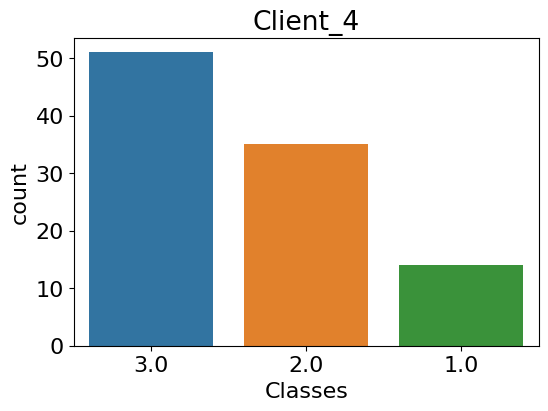

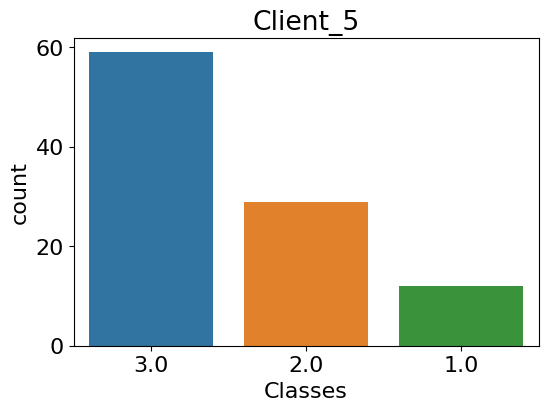

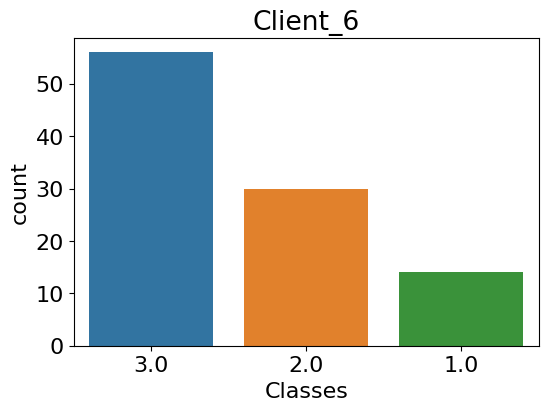

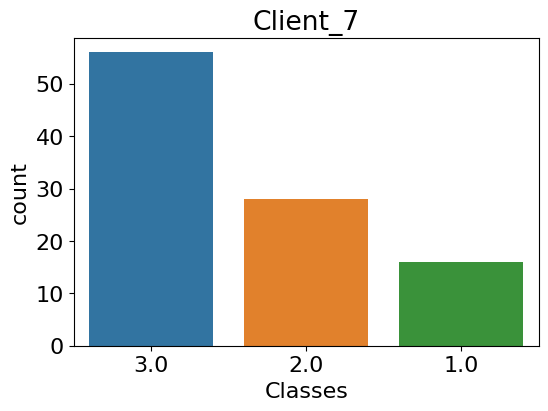

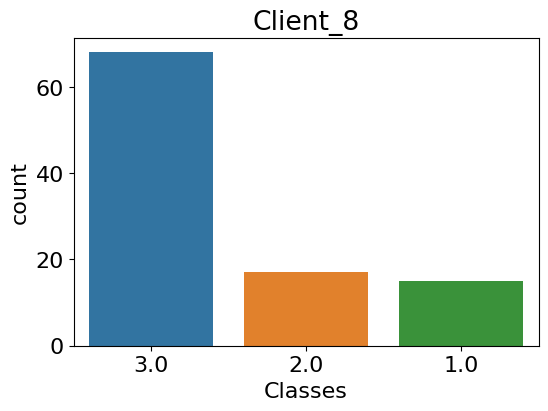

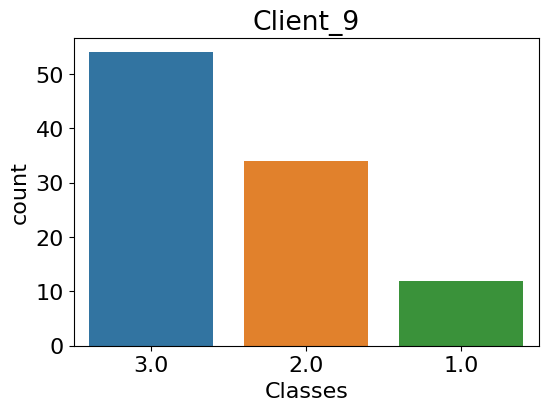

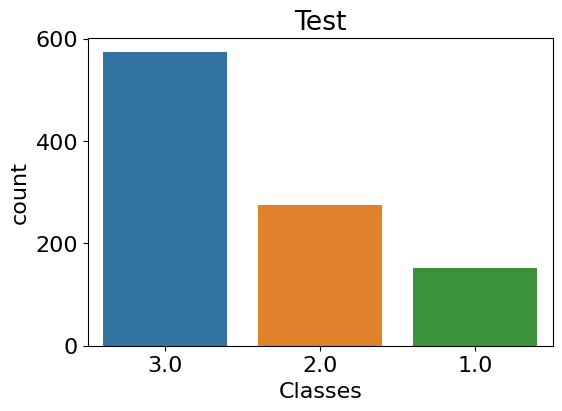

In [ ]:
column_name = ["Classes"]
clients = 10
trainset_client = int(X_train.shape[0]/clients)
valset_client = int(X_val.shape[0]/clients)


for i in range(0,clients):
  df = pd.DataFrame(y_train[(i*trainset_client):((i+1)*trainset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

for i in range(0,clients):
  df = pd.DataFrame(y_val[(i*valset_client):((i+1)*valset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

df = pd.DataFrame(y_test)
df.columns = column_name

# Inspect activities timestamps
plt.figure(figsize=(6,4))
sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
plt.title(f'Test')
plt.show()

# ChlorineConcentration Dataset

In [ ]:
train_data = np.loadtxt(f"./ChlorineConcentration/ChlorineConcentration_TRAIN.txt")
test_data = np.loadtxt(f"./ChlorineConcentration/ChlorineConcentration_TEST.txt")

#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

#Take the last 100 samples of x_train for the validation step
X_val = X_train[-100:]
y_val = y_train[-100:]

X_train = X_train[:-100]
y_train = y_train[:-100]


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3740, 166, 1), (3740,), (100, 166, 1), (100,), (467, 166, 1), (467,))

## Distribution ChlorineConcentration Dataset

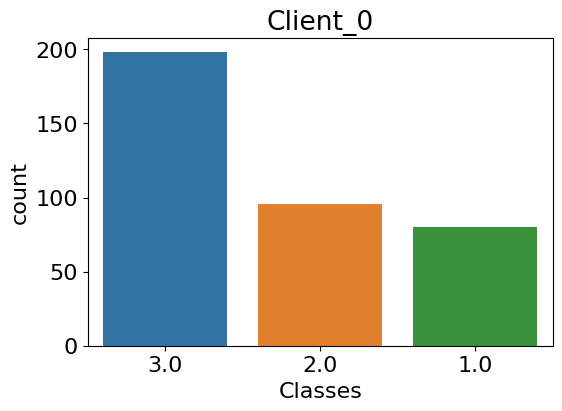

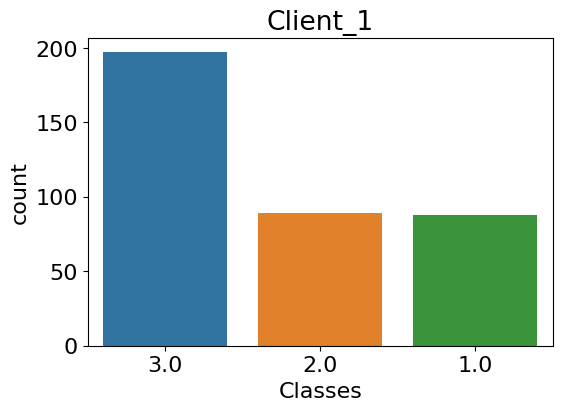

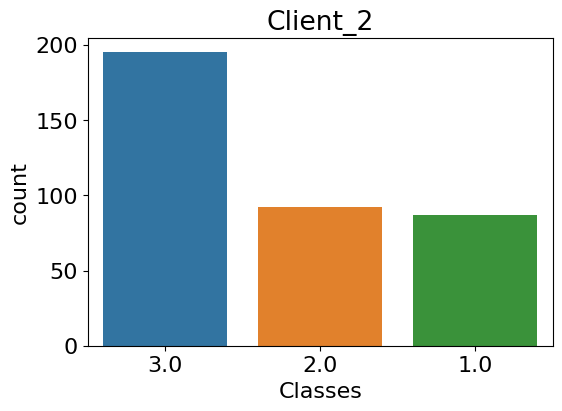

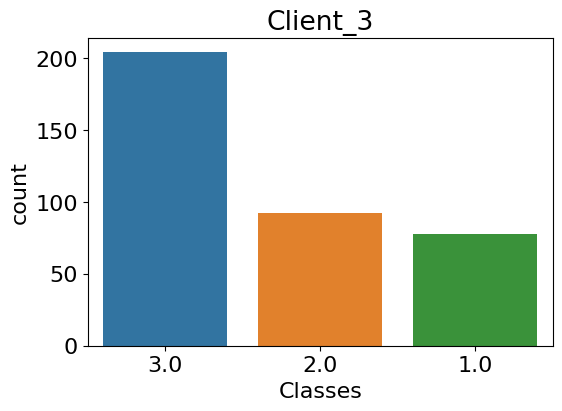

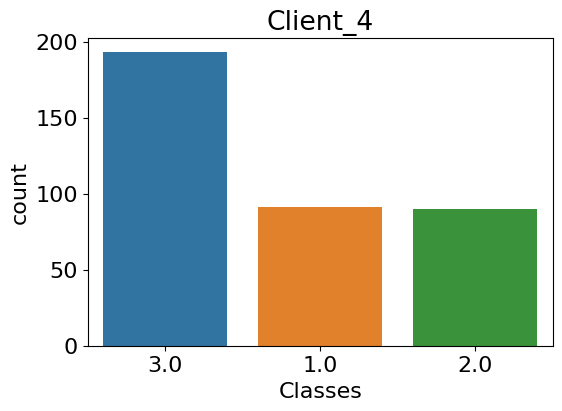

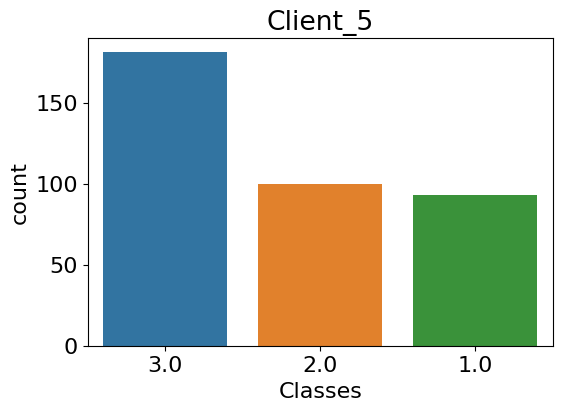

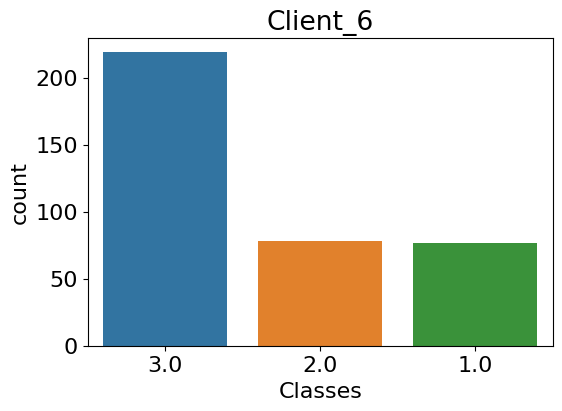

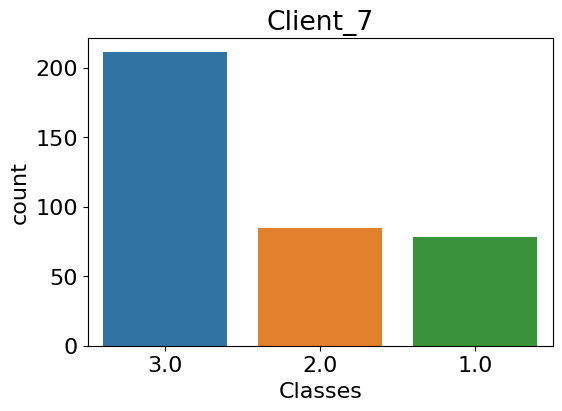

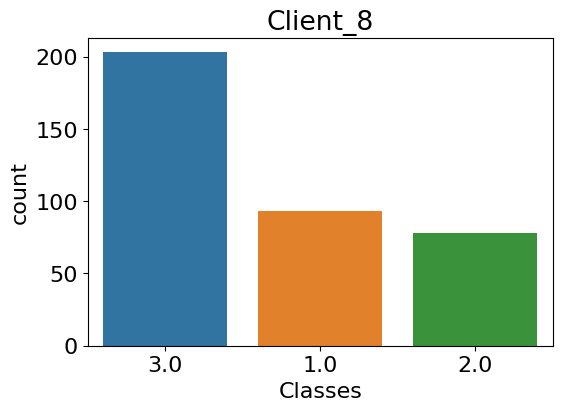

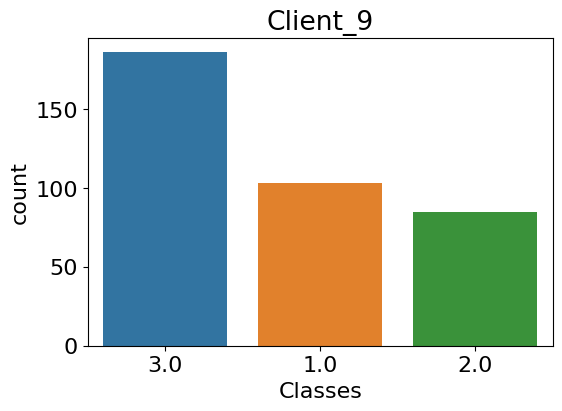

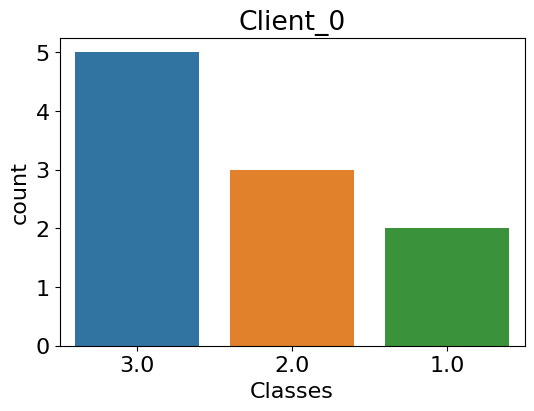

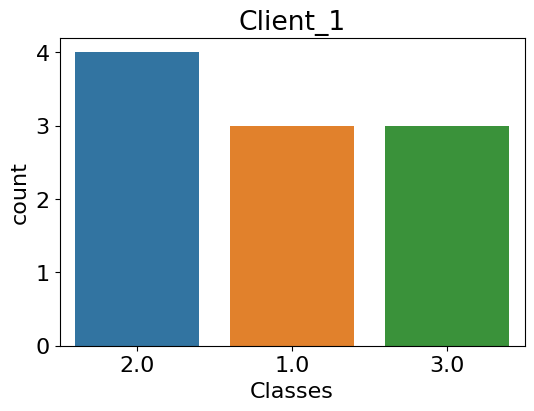

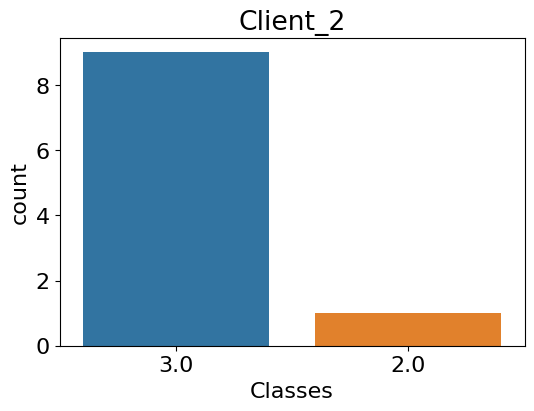

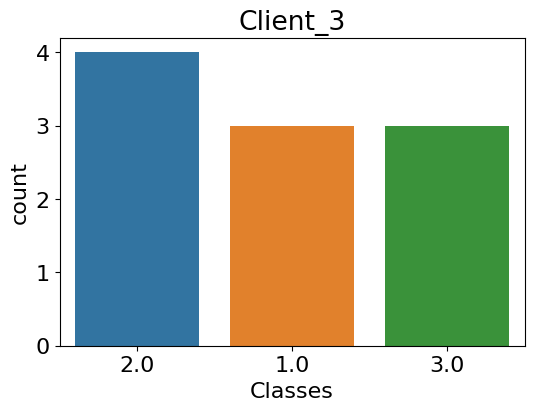

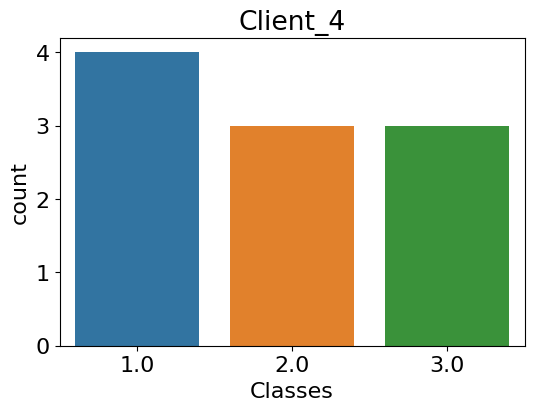

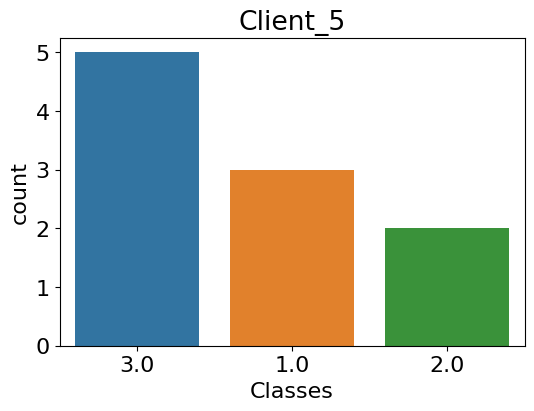

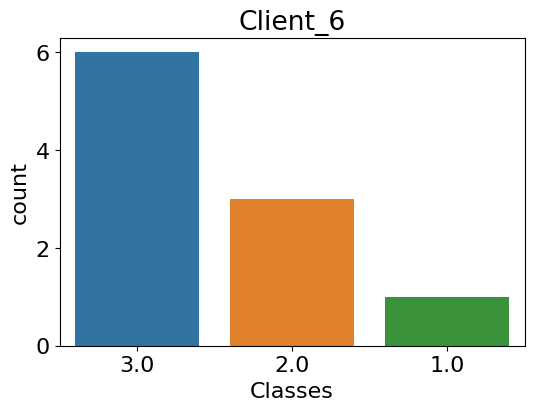

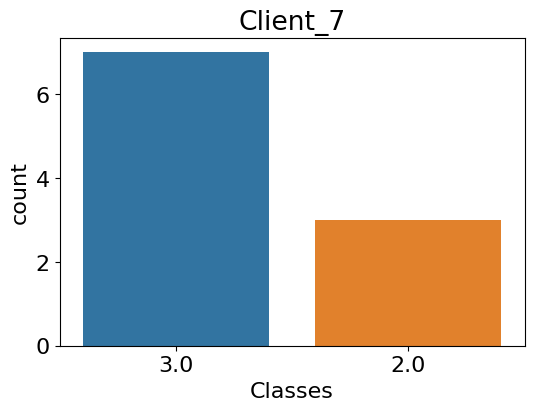

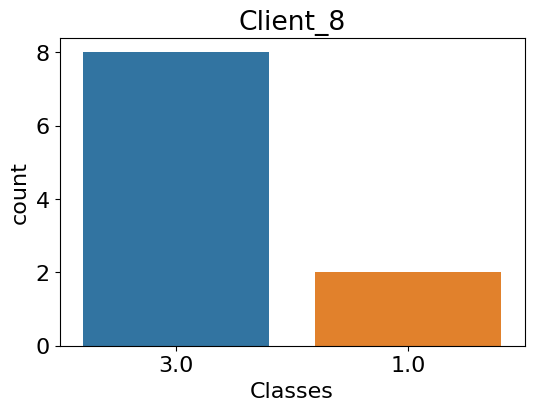

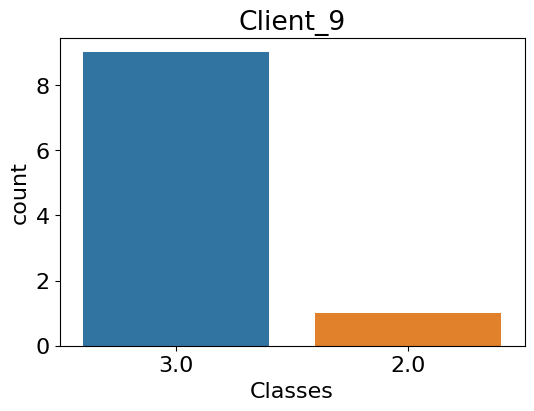

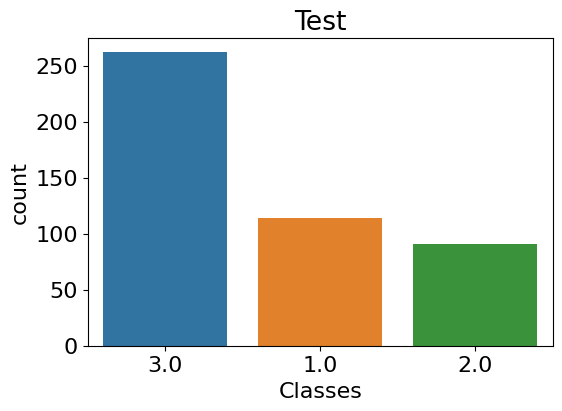

In [ ]:
column_name = ["Classes"]
clients = 10
trainset_client = int(X_train.shape[0]/clients)
valset_client = int(X_val.shape[0]/clients)


for i in range(0,clients):
  df = pd.DataFrame(y_train[(i*trainset_client):((i+1)*trainset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

for i in range(0,clients):
  df = pd.DataFrame(y_val[(i*valset_client):((i+1)*valset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

df = pd.DataFrame(y_test)
df.columns = column_name

# Inspect activities timestamps
plt.figure(figsize=(6,4))
sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
plt.title(f'Test')
plt.show()

# ECG5000 Dataset

In [11]:
train_data = np.loadtxt(f"./Yoga/Yoga_TRAIN.txt")
test_data = np.loadtxt(f"./Yoga/Yoga_TEST.txt")

#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

X_train, y_train = shuffle(X_train, y_train)

#Take the last 100 samples of x_train for the validation step
X_val = X_train[-20:]
y_val = y_train[-20:]

X_train = X_train[:-20]
y_train = y_train[:-20]

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2980, 426, 1), (2980,), (20, 426, 1), (20,), (300, 426, 1), (300,))

# Phalanges Outlines Correct

In [10]:
test_data = np.loadtxt(f"./PhalangesOutlinesCorrect/PhalangesOutlinesCorrect_TRAIN.txt")
train_data = np.loadtxt(f"./PhalangesOutlinesCorrect/PhalangesOutlinesCorrect_TEST.txt")

#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

X_train, y_train = shuffle(X_train, y_train)

#Take the last 100 samples of x_train for the validation step
X_val = X_train[-20:]
y_val = y_train[-20:]

X_train = X_train[:-20]
y_train = y_train[:-20]

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1780, 80, 1), (1780,), (20, 80, 1), (20,), (858, 80, 1), (858,))

# ItalyPowerDemand Dataset

In [11]:
train_data = np.loadtxt(f"./ItalyPowerDemand/ItalyPowerDemand_TRAIN.txt")
test_data = np.loadtxt(f"./ItalyPowerDemand/ItalyPowerDemand_TEST.txt")

#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

X_train, y_train = shuffle(X_train, y_train)

#Take the last 100 samples of x_train for the validation step
X_val = X_train[-10:]
y_val = y_train[-10:]

X_train = X_train[:-10]
y_train = y_train[:-10]

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1019, 24, 1), (1019,), (10, 24, 1), (10,), (67, 24, 1), (67,))

# Distribution Dataset

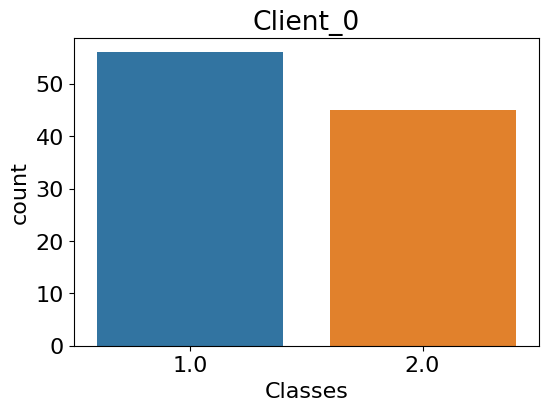

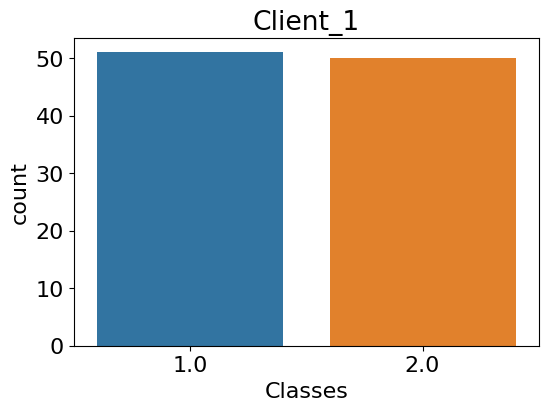

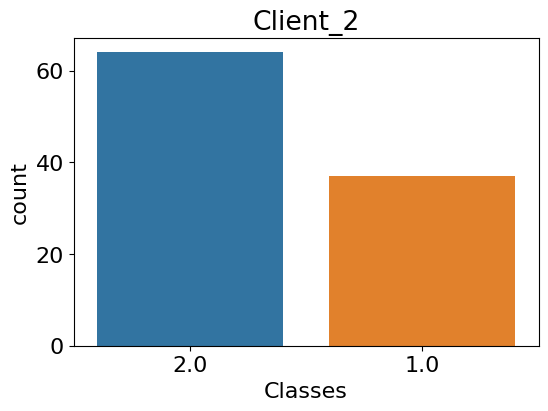

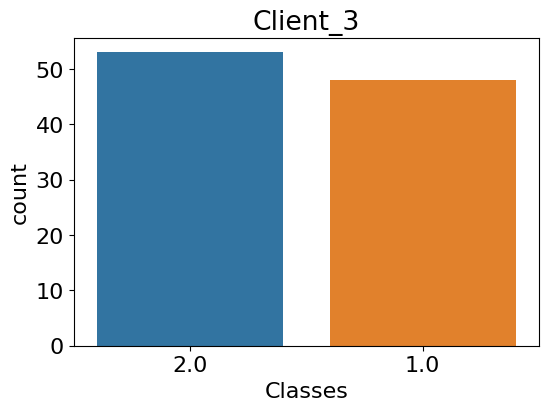

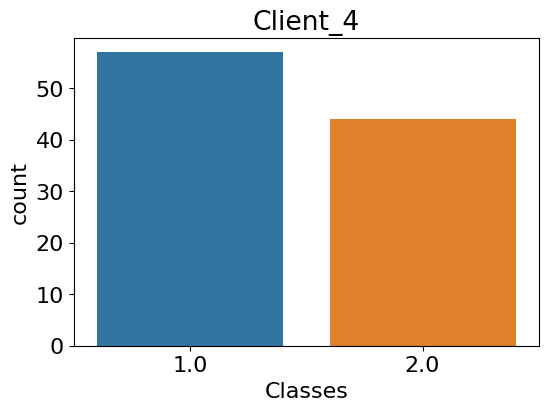

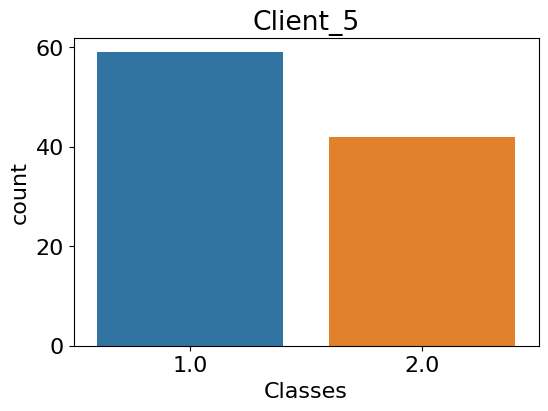

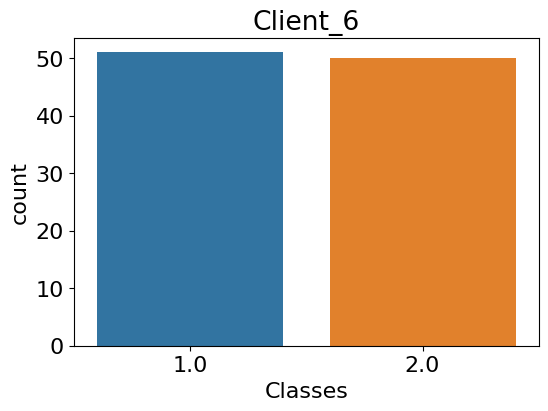

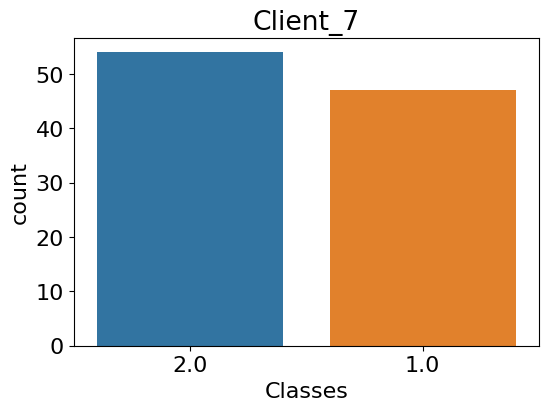

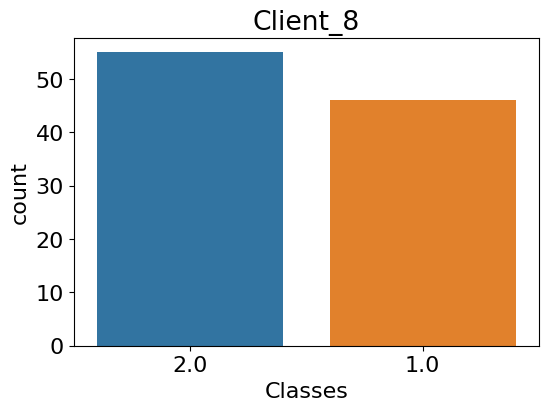

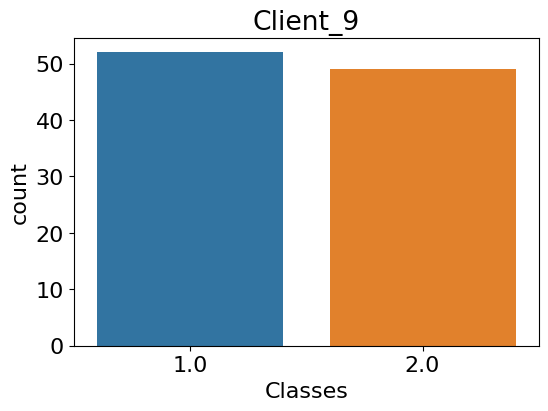

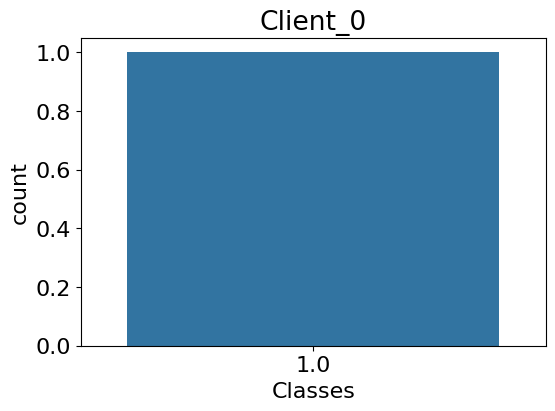

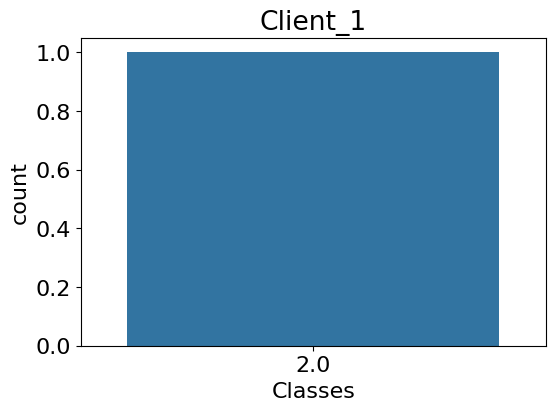

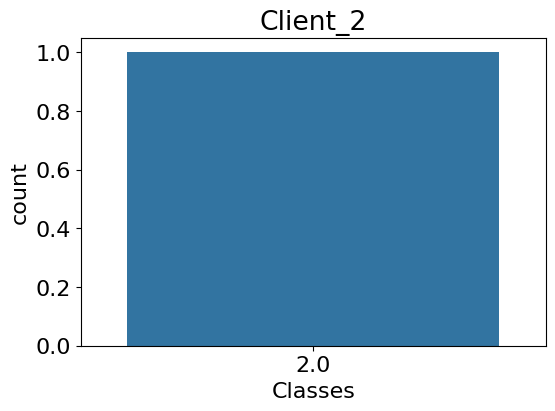

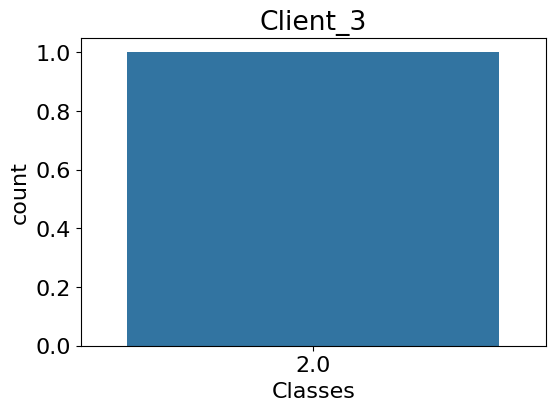

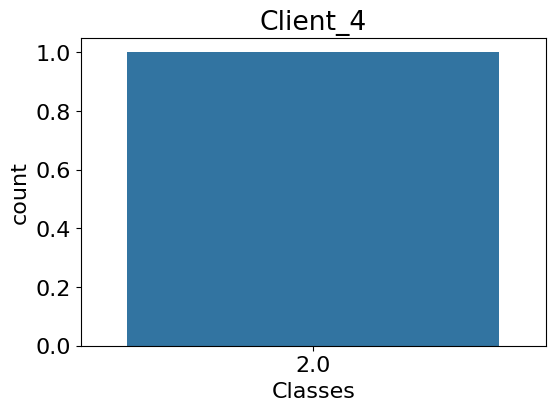

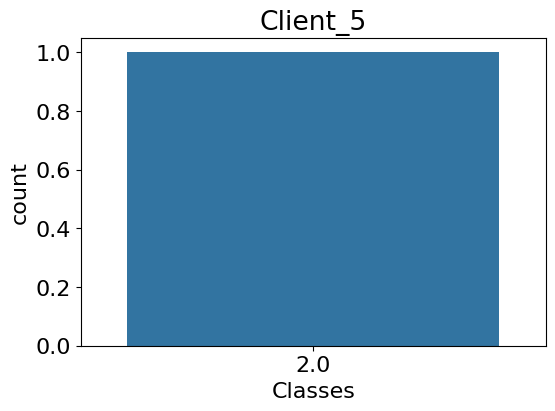

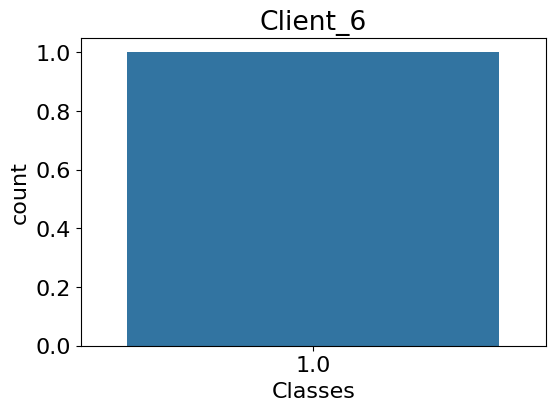

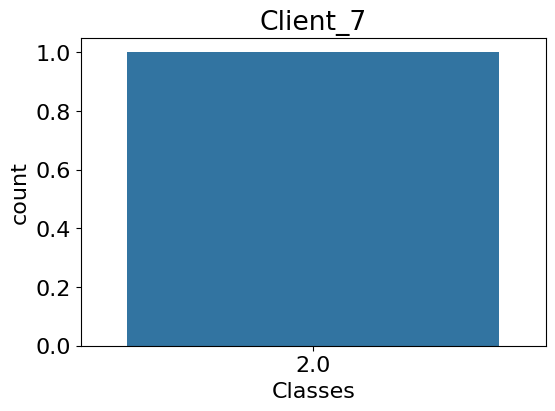

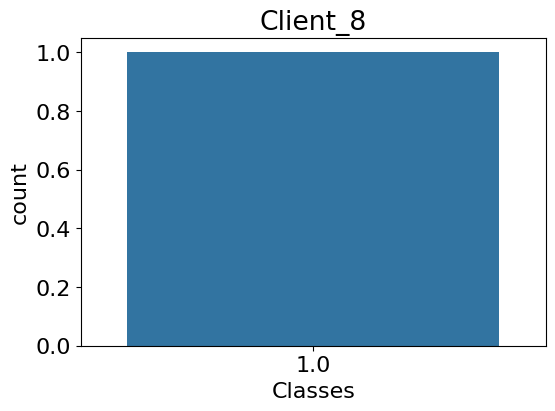

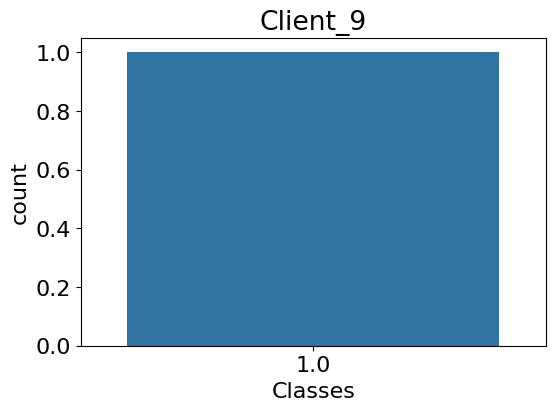

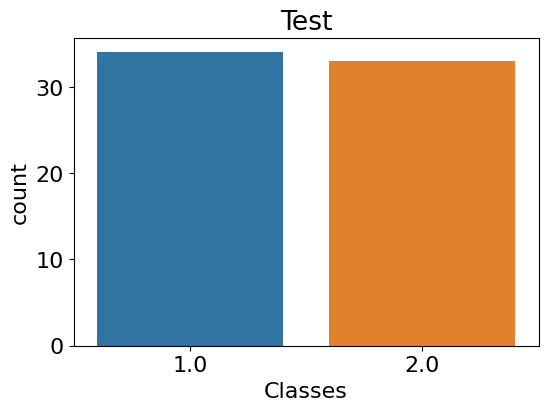

In [12]:
column_name = ["Classes"]
clients = 10
trainset_client = int(X_train.shape[0]/clients)
valset_client = int(X_val.shape[0]/clients)


for i in range(0,clients):
  df = pd.DataFrame(y_train[(i*trainset_client):((i+1)*trainset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

for i in range(0,clients):
  df = pd.DataFrame(y_val[(i*valset_client):((i+1)*valset_client)])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

df = pd.DataFrame(y_test)
df.columns = column_name

# Inspect activities timestamps
plt.figure(figsize=(6,4))
sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
plt.title(f'Test')
plt.show()

# Data Quality Poisoning

In [13]:
## DROPPING DATA: DROPS DATA
def reduce_data_volume(x_train, y_train, options):
    completeness_percentage = options['data_quality_dimension_percentage']
    method = options['experiment_method']

    dropped_percentage = 1 - completeness_percentage

    if method == 'uniform':
        drop_mask = np.random.choice([True, False], x_train.shape[0], p=[1 - dropped_percentage, dropped_percentage])
        return x_train[drop_mask], y_train[drop_mask]

    n_original = x_train.shape[0]
    total_to_drop = int(n_original*dropped_percentage)
    classes, classes_counts = np.unique(y_train, return_counts=True)
    classes_counts_original = dict(zip(classes, classes_counts))

    classes_counts = classes_counts_original.copy()

    sampling_strategy = {i: 0 for i in classes}
    class_to_drop = max(classes_counts_original, key=classes_counts_original.get)

    sampling_strategy[class_to_drop] += total_to_drop
    classes_counts[class_to_drop] -= total_to_drop

    resulting_strategy = {}
    for class_ in classes_counts_original.keys():
        resulting_strategy[class_] = classes_counts_original[class_] - sampling_strategy[class_]

    sampler = RandomUnderSampler(sampling_strategy=resulting_strategy)

    rebalanced_x_train, rebalanced_y_train = sampler.fit_resample(np.squeeze(x_train), y_train)

    permutations = np.random.permutation(rebalanced_x_train.shape[0])
    return np.expand_dims(rebalanced_x_train[permutations], -1), rebalanced_y_train[permutations]

In [14]:
## CONSISTENCY: DUPLICATES AND CHANGES LABELS
def reduce_consistency(x_train, y_train, options):

    consistency_percentage = options['data_quality_dimension_percentage']
    method = options['experiment_method']
    class_list = set(np.unique(y_train))
    original_total = x_train.shape[0]
    n_to_add = int((original_total - consistency_percentage*original_total)/consistency_percentage)
    if method == 'uniform':
        indices = np.arange(0, original_total)
    else:
        classes, classes_counts = np.unique(y_train, return_counts=True)
        classes_counts_original = dict(zip(classes, classes_counts))
        class_to_corrupt = max(classes_counts_original, key=classes_counts_original.get)
        indices = np.squeeze(np.argwhere(y_train == class_to_corrupt))


    inconsistent_indices = np.random.choice(indices, n_to_add)
    x_train_duplicates, y_train_duplicates = x_train[inconsistent_indices].copy(), y_train[inconsistent_indices].copy()
    for i in range(x_train_duplicates.shape[0]):
        y_value = y_train_duplicates[i]
        new_y_value = np.random.choice(list(class_list.difference({y_value})))
        y_train_duplicates[i] = new_y_value


    new_x_train, new_y_train = np.concatenate(
        (x_train, x_train_duplicates)), np.concatenate(
        (y_train, y_train_duplicates))
    permutations = np.random.permutation(new_x_train.shape[0])


    return new_x_train[permutations], new_y_train[permutations]

In [15]:
## ACCURACY: CHANGES LABELS
def reduce_accuracy(x_train, y_train, options):

    accuracy_percentage = options['data_quality_dimension_percentage']
    method = options['experiment_method']
    corrupted_percentage = 1 - accuracy_percentage
    total_amount = x_train.shape[0]
    class_list = set(np.unique(y_train))

    if method == 'uniform':
        for i in range(total_amount):
            if np.random.random() < corrupted_percentage:
                y_value = y_train[i]
                new_y_value = np.random.choice(list(class_list.difference({y_value})))
                y_train[i] = new_y_value

        return x_train, y_train

    classes, classes_counts = np.unique(y_train, return_counts=True)
    classes_counts_original = dict(zip(classes, classes_counts))
    class_to_corrupt = max(classes_counts_original, key=classes_counts_original.get)
    class_percentage = classes_counts_original[class_to_corrupt]/total_amount
    other_classes = list(class_list.difference({class_to_corrupt}))

    class_percentage_to_corrupt = corrupted_percentage/class_percentage
    for i in range(total_amount):
        y_value = y_train[i]
        if y_value == class_to_corrupt and np.random.random() < class_percentage_to_corrupt:

            new_y_value = np.random.choice(other_classes)
            y_train[i] = new_y_value

    return x_train, y_train


In [16]:
## COMPLETENESS: Deletes inner points
def reduce_completeness(x_train, y_train, options):
    accuracy_percentage = options['data_quality_dimension_percentage']
    method = options['experiment_method']
    inner_missing_percentage = 0.4

    number_of_sequences, length_of_sequence, dimensions = x_train.shape
    number_of_missing_points_per_sequence = int(inner_missing_percentage*length_of_sequence)

    total_amount = x_train.shape[0]

    if method == 'uniform':
        while True:
            affected_percentage = (1 - accuracy_percentage)/inner_missing_percentage
            if affected_percentage <= 1:
                break

            inner_missing_percentage *= 1.02
        for i in range(total_amount):
            if np.random.random() < affected_percentage:
                start = np.random.randint(0, length_of_sequence-number_of_missing_points_per_sequence)
                x_train[i][start: start + number_of_missing_points_per_sequence] = np.mean(x_train[i])

        return x_train, y_train

    class_list = set(np.unique(y_train))
    classes, classes_counts = np.unique(y_train, return_counts=True)
    classes_counts_original = dict(zip(classes, classes_counts))
    class_to_corrupt = max(classes_counts_original, key=classes_counts_original.get)
    class_percentage = classes_counts_original[class_to_corrupt]/total_amount
    affected_class_percentage = min(1, (1 - accuracy_percentage)/(inner_missing_percentage*class_percentage))
    while True:
        actual_accuracy_percentage = 1 - inner_missing_percentage*class_percentage*affected_class_percentage

        if actual_accuracy_percentage <= accuracy_percentage:
            break

        inner_missing_percentage *= 1.02
        affected_class_percentage = min(1, (1 - accuracy_percentage)/(inner_missing_percentage*class_percentage))

    number_of_missing_points_per_sequence = int(inner_missing_percentage*length_of_sequence)
    for i in range(total_amount):
        y_value = y_train[i]
        if y_value == class_to_corrupt and np.random.random() < affected_class_percentage:
            start = np.random.randint(0, length_of_sequence-number_of_missing_points_per_sequence)
            x_train[i][start: start + number_of_missing_points_per_sequence] = np.mean(x_train[i])

    return x_train, y_train

# Load Parameters and Partitions

In [17]:
#This is done to poison the data points correctly
Y_TRAIN = y_train

In [18]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1019, 24, 1), (1019, 3), (67, 24, 1), (67, 3), (10, 24, 1), (10, 3))

In [19]:
X_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = X_train, X_val, y_val, X_test, y_test

In [20]:
# The partitions must be set accordingly to the Data quality we want, so it must be set as a parameter that changes
def load_partition(idx: int):
    """Load 1/5th of the training and test data to simulate a partition."""
    return (
        X_TRAIN[idx * trainset_client : (idx + 1) * trainset_client],
        Y_TRAIN[idx * trainset_client : (idx + 1) * trainset_client],
    ), (
        X_VAL[idx * valset_client : (idx + 1) * valset_client],
        Y_VAL[idx * valset_client : (idx + 1) * valset_client],
    )

In [21]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

# ResNet model

In [22]:
def build_ResNet(input_shape, classes):
    n_feature_maps = 64
    input_layer = tfkl.Input(input_shape)

    # BLOCK 1

    conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_1 = tfkl.add([shortcut_y, conv_z])
    output_block_1 = tfkl.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_2 = tfkl.add([shortcut_y, conv_z])
    output_block_2 = tfkl.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = tfkl.BatchNormalization()(output_block_2)

    output_block_3 = tfkl.add([shortcut_y, conv_z])
    output_block_3 = tfkl.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

    output_layer = tfkl.Dense(classes, activation='softmax')(gap_layer)

    model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [22]:
model_info = build_ResNet(input_shape, classes)

# Flower Client

In [23]:
#Define the CifarClient
class CifarClient(fl.client.Client):
    def __init__(self, cid, model, x_train, y_train, x_test, y_test):
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.measure_parameters  = {
              'effective_epochs': 0,
              'effective_emissions_kg': 0,
              'effective_energy_consumed': 0,
              'effective_duration': 0
        }

    '''
    def get_properties(self, config):
        """Get properties of client."""
        raise Exception("Not implemented")
    '''

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        """Get parameters of the local model."""
        # raise Exception("Not implemented (server-side parameter initialization)")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = self.model.get_weights()

        # Serialize ndarray's into a Parameters object
        parameters = ndarrays_to_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        """Train parameters on the locally held training set."""
        print("Starting Fit")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model parameters
        self.model.set_weights(ndarrays_original)

        # Get hyperparameters for this round
        batch_size: int = ins.config["batch_size"]
        epochs: int = ins.config["local_epochs"]
        #quality_value = ins.config["quality_percentage"] #Only with vertical strategy
        #server_round = ins.config["round"] #Only with vertical strategy
        batch_size = int(min(self.x_train.shape[0] / 10, batch_size))
        print("The batch_size is {}".format(batch_size))
        print("The epochs are {}".format(epochs)) #Only with vertical strategy
        #print("The quality percentage is {}".format(quality_value)) #Only with vertical strategy

        #options = {'data_quality_dimension_percentage': quality_value, 'experiment_method': 'uniform'} #Only with vertical strategy
        #For Vertical Consistency experiments
        #self.x_train, self.y_train = reduce_consistency(self.x_train, self.y_train, options)
        #For Vertical Accuracies experiments
        #elf.x_train, self.y_train = reduce_accuracy(self.x_train, self.y_train, options)
        #For Vertical Completeness experiments
        #self.x_train, self.y_train = reduce_completeness(self.x_train, self.y_train, options)
        print(self.y_train.shape)
        #Remember that for Vertical experiments reduce_consistency doesn't want categorical values
        #self.y_train = tfk.utils.to_categorical(self.y_train)

        with OfflineEmissionsTracker(country_iso_code="ITA", project_name=1, log_level='warning') as tracker:
          start_time = time.time()

          # Train the model using hyperparameters from config
          history = self.model.fit(
             x=self.x_train,
             y=self.y_train,
             batch_size=batch_size,
             epochs=epochs,
             validation_split=.1,
             callbacks=[
                 tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=20, factor=0.5,
                                                 min_lr=0.0001),
              ]
          )
          self.measure_parameters['effective_duration'] = time.time() - start_time

        self.measure_parameters['effective_energy_consumed'] = tracker.final_emissions_data.energy_consumed
        self.measure_parameters['effective_emissions_kg'] = tracker.final_emissions
        self.measure_parameters['effective_epochs'] = len(history.epoch)

        print(self.measure_parameters)

        # Return updated model parameters and results
        parameters_prime = self.model.get_weights()
        parameters_updated = ndarrays_to_parameters(parameters_prime)

        num_examples_train = len(self.x_train)
        results = {
            "loss": history.history["loss"][0],
            "accuracy": history.history["accuracy"][0],
            "val_loss": history.history["val_loss"][0],
            "val_accuracy": history.history["val_accuracy"][0],
            "emission_kg": self.measure_parameters['effective_emissions_kg'],
            "energy_consumed": self.measure_parameters['effective_energy_consumed'],
            "duration": self.measure_parameters['effective_duration'],
            "epochs": self.measure_parameters['effective_epochs'],
        }

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=num_examples_train,
            metrics=results,
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        """Evaluate parameters on the locally held test set."""

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model with global parameters
        self.model.set_weights(ndarrays_original)

        # Get config values
        steps: int = ins.config["val_steps"]

        # Evaluate global model parameters on the local test data and return results
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, 32, steps=steps)
        num_examples_test = len(self.x_test)
        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=num_examples_test,
            metrics={"accuracy": float(accuracy)},
        )

In [24]:
def get_client_fn(volume, quality):
  # It must be called to create an instance of a new FlowerClient
  def client_fn(cid: str) -> CifarClient:
      """Create a Flower client representing a single organization."""

      # Note: each client gets a different trainloader/valloader, so each client
      # will train and evaluate on their own unique data
      print("Client with CID: {}\n".format(int(cid)))
      options_volume = {'data_quality_dimension_percentage': volume, 'experiment_method': 'uniform'}
      options_quality = {'data_quality_dimension_percentage': quality, 'experiment_method': 'uniform'}
      (x_train, y_train), (x_test, y_test) = load_partition(int(cid))

      #Data quality poisoning
      x_train, y_train = reduce_data_volume(x_train, y_train, options_volume)
      #Reduce Consistency Horizontally
      #x_train, y_train = reduce_consistency(x_train, y_train, options_consistency)
      #Reduce Accuracy Horizontally
      #x_train, y_train = reduce_accuracy(x_train, y_train, options_quality)
      #This is just to take the right shape and build the model
      y_train = tfk.utils.to_categorical(y_train)

      # Load model
      model_client = build_ResNet(x_train.shape[1:], y_train.shape[-1])

      # Create a  single Flower client representing a single organization
      return CifarClient(cid, model_client, x_train, y_train, x_test, y_test)
  return client_fn

# Strategy

### Strategy Basic

In [ ]:
#This strategy keeps the clients to be trained fixed after each round, used for horizontal experiments
class CustomClientConfigStrategy_basic(fl.server.strategy.FedAvg):
    def __init__(self, file_path, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_path = file_path
        self.measure_parameters  = {
              'effective_epochs': 0,
              'effective_emissions_kg': 0,
              'effective_energy_consumed': 0,
              'effective_duration': 0
        }

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        #This method is called at the beginning of each round in order to choose and select the clients to be trained
        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )

        clients = client_manager.sample(
             num_clients=sample_size, min_num_clients=min_num_clients
        )

        print(f"Round {server_round} will sample clients: {[client.cid for client in clients]}")

        # Create custom configs in order to change and personalize the config per each client
        n_clients = len(clients)
        half_clients = n_clients // 2
        #The value of the batch_size is the maximum value possible
        standard_config = {"batch_size": 64, "local_epochs": 40}
        new_config = {"batch_size": 64, "local_epochs": 40}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, new_config))
                )
        return fit_configurations


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        #Compute emission and duration
        for _, res in results:
          self.measure_parameters['effective_emissions_kg'] += res.metrics['emission_kg']
          self.measure_parameters['effective_energy_consumed'] += res.metrics['energy_consumed']
          self.measure_parameters['effective_duration'] += res.metrics['duration']
          self.measure_parameters['effective_epochs'] += res.metrics['epochs']

        if(server_round == 6):
          with open(self.file_path, "r") as json_file:
            data = json.load(json_file)

          last_obj = data[-1]
          last_obj['effective_emissions_kg'] = self.measure_parameters['effective_emissions_kg']
          last_obj['effective_energy_consumed'] = self.measure_parameters['effective_energy_consumed']
          last_obj['effective_duration'] = self.measure_parameters['effective_duration']
          last_obj['effective_epochs'] = self.measure_parameters['effective_epochs']

          with open(self.file_path, "w") as json_file:
            json.dump(data, json_file)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

### Strategy Vertical Fixed

In [25]:
#This strategy keeps the clients to be trained fixed after each round
class CustomClientConfigStrategy_fixed(fl.server.strategy.FedAvg):
    def __init__(self, file_path, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_path = file_path
        self.measure_parameters  = {
              'effective_epochs': 0,
              'effective_emissions_kg': 0,
              'effective_energy_consumed': 0,
              'effective_duration': 0
        }

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        #This method is called at the beginning of each round in order to choose and select the clients to be trained
        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )

        if server_round == 1:
          clients = client_manager.sample(
              num_clients=sample_size, min_num_clients=min_num_clients
          )
          print(f"Round {server_round} will sample clients: {[client.cid for client in clients]}")
        # Otherwise I select the same clients as the previous round
        else:
          clients = [cli for cli in self.prev_clients]
          print(f"Round {server_round} will resample clients: {[client.cid for client in clients]}")

        # record client proxies
        self.prev_clients = clients

        # Create custom configs in order to change and personalize the config per each client
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"batch_size": 64, "local_epochs": 40}
        new_config = {"batch_size": 64, "local_epochs": 40}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, new_config))
                )
        return fit_configurations


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        #Compute emission and duration
        for _, res in results:
          self.measure_parameters['effective_emissions_kg'] += res.metrics['emission_kg']
          self.measure_parameters['effective_energy_consumed'] += res.metrics['energy_consumed']
          self.measure_parameters['effective_duration'] += res.metrics['duration']
          self.measure_parameters['effective_epochs'] += res.metrics['epochs']

        if(server_round == 6):
          with open(self.file_path, "r") as json_file:
            data = json.load(json_file)

          last_obj = data[-1]
          last_obj['effective_emissions_kg'] = self.measure_parameters['effective_emissions_kg']
          last_obj['effective_energy_consumed'] = self.measure_parameters['effective_energy_consumed']
          last_obj['effective_duration'] = self.measure_parameters['effective_duration']
          last_obj['effective_epochs'] = self.measure_parameters['effective_epochs']

          with open(self.file_path, "w") as json_file:
            json.dump(data, json_file)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

### Strategy Vertical Quality

In [ ]:
#This strategy keeps the clients to be trained fixed after each round
class CustomClientConfigStrategy_vertical(fl.server.strategy.FedAvg):
    def __init__(self, vertical_quality, file_path, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vertical_quality = vertical_quality
        self.file_path = file_path
        self.measure_parameters  = {
              'effective_epochs': 0,
              'effective_emissions_kg': 0,
              'effective_energy_consumed': 0,
              'effective_duration': 0
        }

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        #This method is called at the beginning of each round in order to choose and select the clients to be trained
        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )

        if server_round == 1:
          clients = client_manager.sample(
              num_clients=sample_size, min_num_clients=min_num_clients
          )
          print(f"Round {server_round} will sample clients: {[client.cid for client in clients]}")
        # Otherwise I select the same clients as the previous round
        else:
          clients = [cli for cli in self.prev_clients]
          print(f"Round {server_round} will resample clients: {[client.cid for client in clients]}")

        # record client proxies
        self.prev_clients = clients

        #Apply quality dimension only to a defined percentage of clients
        fit_configurations = []
        config_affected = {"batch_size": 64, "local_epochs": 40, "quality_percentage": 0.5, "round": server_round}
        config_not_affected = {"batch_size": 64, "local_epochs": 40, "quality_percentage": 1.0, "round": server_round}
        n_clients = len(clients)
        num_clients_affected = num_clients - (int(n_clients*self.vertical_quality))
        #Take the first num_clients_affected from the list of clients selected randomly at the beginning
        clients_affected = clients[:num_clients_affected]
        for client in clients_affected:
          fit_configurations.append((client, FitIns(parameters, config_affected)))

        clients_not_affected = clients[num_clients_affected:]
        for client in clients_not_affected:
          fit_configurations.append((client, FitIns(parameters, config_not_affected)))

        return fit_configurations


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        #Compute emission and duration
        for _, res in results:
          self.measure_parameters['effective_emissions_kg'] += res.metrics['emission_kg']
          self.measure_parameters['effective_energy_consumed'] += res.metrics['energy_consumed']
          self.measure_parameters['effective_duration'] += res.metrics['duration']
          self.measure_parameters['effective_epochs'] += res.metrics['epochs']

        if(server_round == 6):
          with open(self.file_path, "r") as json_file:
            data = json.load(json_file)

          last_obj = data[-1]
          last_obj['effective_emissions_kg'] = self.measure_parameters['effective_emissions_kg']
          last_obj['effective_energy_consumed'] = self.measure_parameters['effective_energy_consumed']
          last_obj['effective_duration'] = self.measure_parameters['effective_duration']
          last_obj['effective_epochs'] = self.measure_parameters['effective_epochs']

          with open(self.file_path, "w") as json_file:
            json.dump(data, json_file)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

### Strategy Vertical Set

In [ ]:
#This strategy sample the clients to be trained from a random set of clients fixed per each round
class CustomClientConfigStrategy_set(fl.server.strategy.FedAvg):
    def __init__(self, num_set_samples, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_samples = num_set_samples
        self.measure_parameters  = {
              'effective_epochs': 0,
              'effective_emissions_kg': 0,
              'effective_energy_consumed': 0,
              'effective_duration': 0
        }

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        #This method is called at the beginning of each round in order to choose and select the clients to be trained
        # Sample clients, sample_size == the number of clients that must be selected, min_available_clients == N_CLIENTS
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )

        size_all = 8

        if server_round == 1:
          #Define the fixed set of clients to be trained
          self.sample_clients = random.sample(range(0, 8), self.num_samples)

          #Retrieve all the clients
          clients_all = client_manager.sample(
              num_clients=size_all, min_num_clients=min_num_clients
          )

          #Retrieve the clients that corresponds to set defined before
          for cli in clients_all:
            if cli.cid in self.sample_clients:
              self.set_clients
          self.set_clients = [cli for cli in clients_all if int(cli.cid) in self.sample_clients]
          print(f"The initial set of clients is {self.sample_clients}")

        clients = random.sample(self.set_clients, sample_size)
        print(f"Round {server_round} will sample clients: {[client.cid for client in clients]}")


        # Create custom configs in order to change and personalize the config per each client
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"batch_size": 64, "local_epochs": 40}
        new_config = {"batch_size": 64, "local_epochs": 40}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, new_config))
                )
        print("Config ended")
        return fit_configurations


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        #Compute emission and duration
        for _, res in results:
          self.measure_parameters['effective_emissions_kg'] += res.metrics['emission_kg']
          self.measure_parameters['effective_energy_consumed'] += res.metrics['energy_consumed']
          self.measure_parameters['effective_duration'] += res.metrics['duration']
          self.measure_parameters['effective_epochs'] += res.metrics['epochs']

        if(server_round == 6):
          file_path = '/gdrive/My Drive/Tesi Notebooks/results_vertical.json'
          with open(file_path, "r") as json_file:
            data = json.load(json_file)

          last_obj = data[-1]
          last_obj['effective_emissions_kg'] = self.measure_parameters['effective_emissions_kg']
          last_obj['effective_energy_consumed'] = self.measure_parameters['effective_energy_consumed']
          last_obj['effective_duration'] = self.measure_parameters['effective_duration']
          last_obj['effective_epochs'] = self.measure_parameters['effective_epochs']

          with open(file_path, "w") as json_file:
            json.dump(data, json_file)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated


# Server Functions

In [26]:
def get_evaluate_fn(model, x_test, y_test, file_path):
    """Return an evaluation function for server-side evaluation."""
    print("Evaluate loading")

    # The `evaluate` function will be called after every round
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test)

        with open(file_path, "r") as json_file:
          data = json.load(json_file)

        last_obj = data[-1]
        last_obj[f"Accuracy_{server_round}"] = accuracy

        with open(file_path, "w") as json_file:
          json.dump(data, json_file)

        return loss, {"accuracy": accuracy}

    return evaluate


def evaluate_config(server_round: int):
    """Return evaluation configuration dict for each round.

    Perform five local evaluation steps on each client (i.e., use five
    batches) during rounds one to three, then increase to ten local
    evaluation steps.
    """
    val_steps = 3 if server_round < 4 else 5
    return {"val_steps": val_steps}


In [26]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Simulation

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 64
FRACTION_FIT = 0.2
NUM_SET_CLIENTS = 10
DATA_VOLUME = 1.0
CONSISTENCY = 0.0
ACCURACY = 0.0
COMPLETENESS = 0.0


#Only if it si vertical
OFFSET = 0.1
num_clients = int(NUM_CLIENTS * FRACTION_FIT)
number_clients_considered = (int)(NUM_CLIENTS * FRACTION_FIT)
volume_data = num_clients * 0.1 #0.125 is the fraction of dataset per each client
#This is for the mix
vertical_quality = (float)(OFFSET * (number_clients_considered - (int)(ACCURACY * (number_clients_considered)))) + ACCURACY

file_path = '/gdrive/My Drive/Tesi Notebooks/ItalyPowerDemand/results/Data Volume/vertical_results.json'
if not os.path.exists(file_path):
  options = [{'experiment_method': 'vertical_volume', 'data_volume': DATA_VOLUME, 'num_clients': (int)(NUM_CLIENTS*FRACTION_FIT), 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
  with open(file_path, "w") as json_file:
    json.dump(options, json_file)
else:
  options = {'experiment_method': 'vertical_volume', 'data_volume': DATA_VOLUME, 'num_clients': (int)(NUM_CLIENTS*FRACTION_FIT), 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
  with open(file_path, "r") as json_file:
    data = json.load(json_file)
    data.append(options)
  with open(file_path, "w") as json_file:
    json.dump(data, json_file)

index_experiment = 0

new_model = build_ResNet(input_shape, classes)

# Create strategy
strategy_basic = CustomClientConfigStrategy_fixed(
    file_path = file_path,
    fraction_fit=FRACTION_FIT,
    fraction_evaluate=0.1,
    min_fit_clients=1,
    min_evaluate_clients=1,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
    # on_fit_config_fn=fit_config,
    on_evaluate_config_fn=evaluate_config,
    initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
)

single_client_gpu_access = 1
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(DATA_VOLUME, ACCURACY),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=6),
    strategy=strategy_basic,
    #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
    client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    }
)

INFO flwr 2023-11-08 19:39:47,848 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


In [ ]:
file_path = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/vertical_accuracy.json'

with open(file_path, "r") as json_file:
    data = json.load(json_file)
data = data[:-1]
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

# Graphical Results

In [ ]:
def create_curve(x_values_v, y_values_v):
  model = LinearRegression()
  x_values = np.array(x_values_v).reshape(-1, 1)
  model.fit(np.log(x_values), y_values_v)
  C1 = model.intercept_
  C2 = model.coef_[0]
  curve = C1 + C2 * np.log(x_values_v)

  return curve

## StarLightCurves

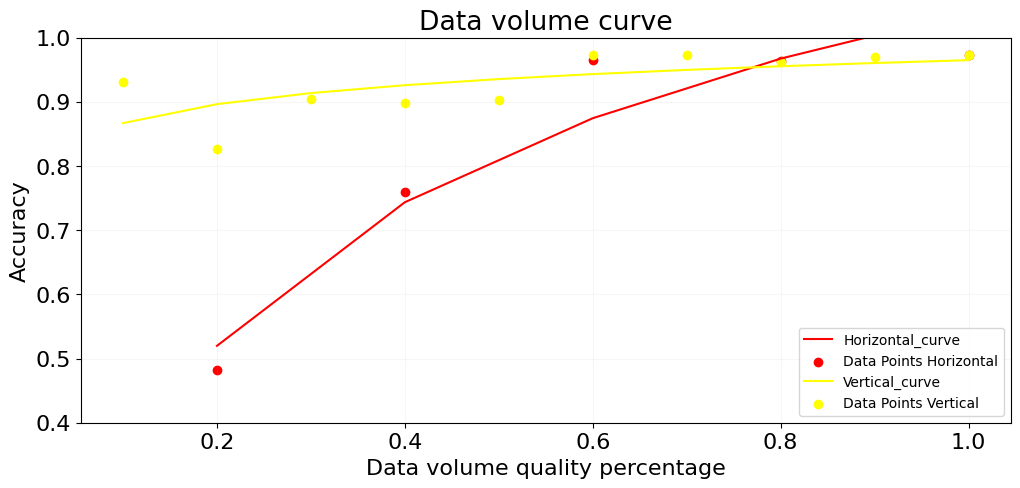

In [ ]:
#Curves Comparison Data Volume Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_horizontal.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_vertical.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["data_volume"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append((0.1*object_experiment["num_clients"]))

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.title("Data volume curve")
plt.xlabel("Data volume quality percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.ylim([0.4, 1.0])
plt.legend(fontsize=10)
plt.show()

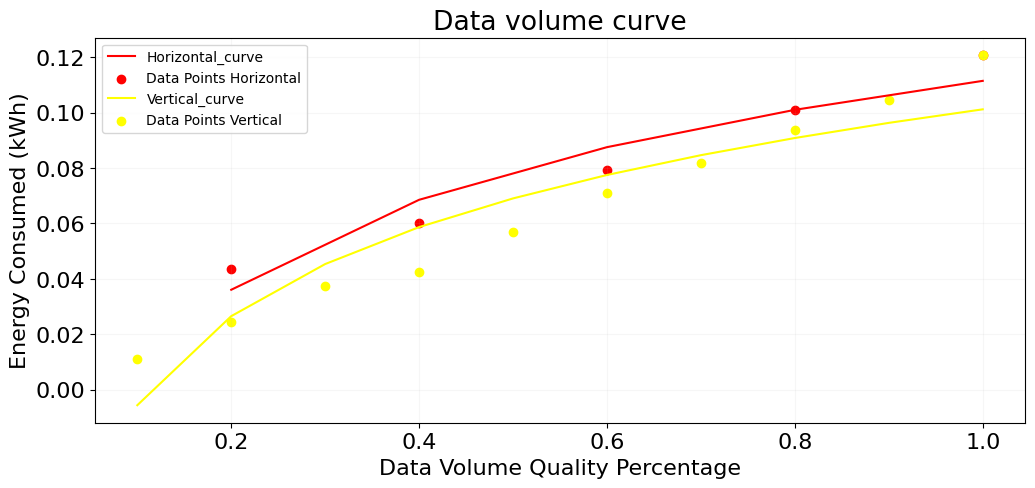

In [ ]:
#Curves Comparison Data Volume Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_horizontal.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_vertical.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["data_volume"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append((0.1*object_experiment["num_clients"]))


plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.title("Data volume curve")
plt.xlabel("Data Volume Quality Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

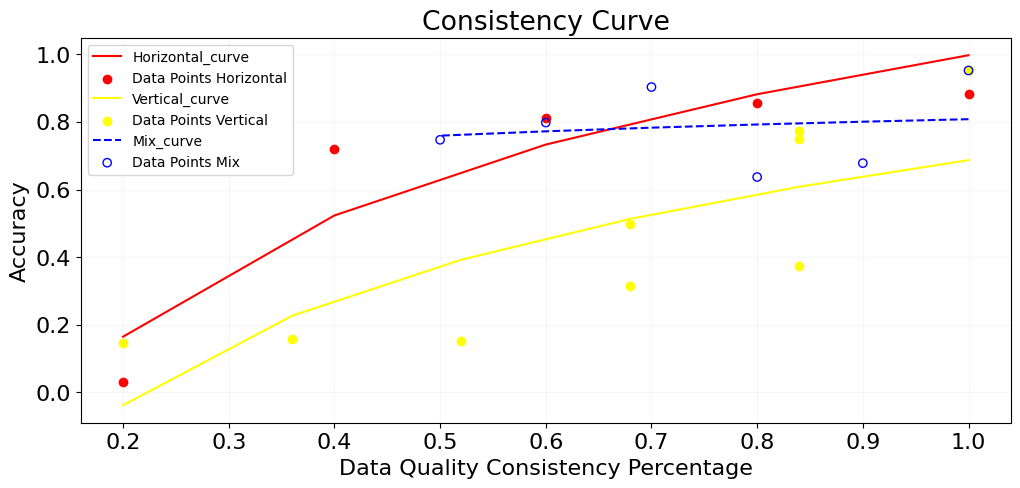

In [ ]:
#Curves Comparison Consistency Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/horizontal_consistency.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/vertical_consistency.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/mix_consistency.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["consistency"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["consistency"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["consistency"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h,  color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Consistency Curve")
plt.xlabel("Data Quality Consistency Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

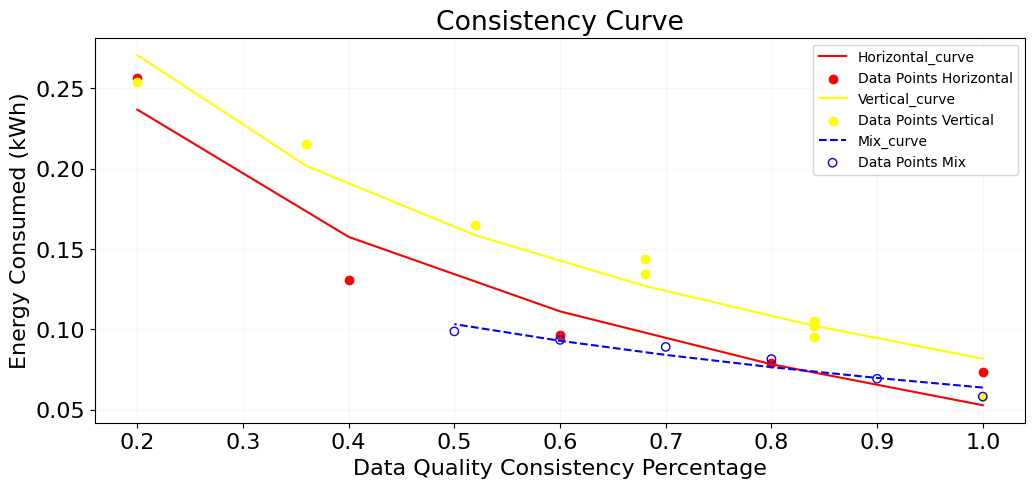

In [ ]:
#Curves Comparison Consistency Horizontally and Vertical energy consumation
#Curves Comparison Consistency Horizontally and Vertical energy consumed
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/horizontal_consistency.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/vertical_consistency.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Consistency/mix_consistency.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["consistency"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["consistency"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["consistency"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Consistency Curve")
plt.xlabel("Data Quality Consistency Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

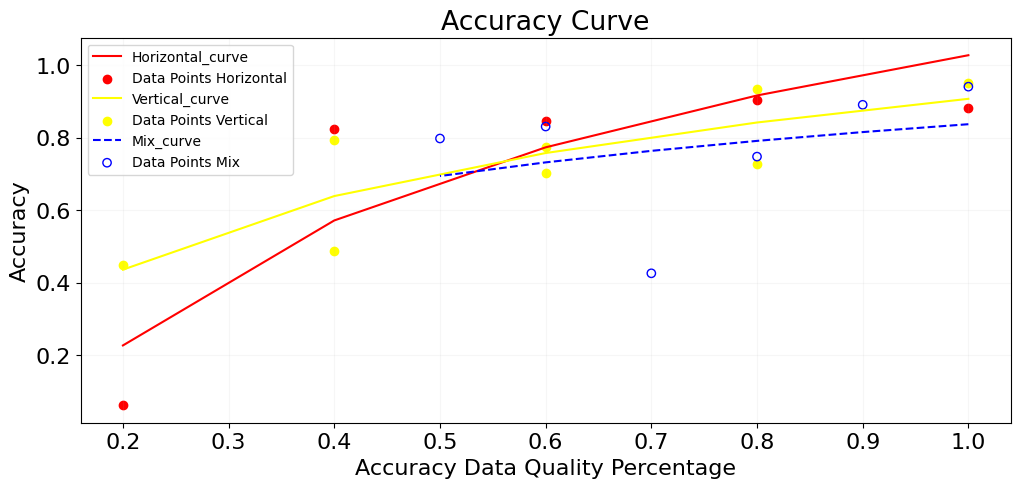

In [ ]:
#Curves Comparison Accuracy Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/horizontal_accuracy.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/vertical_accuracy.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/mix_accuracy.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["accuracy"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["accuracy"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["accuracy"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Accuracy Curve")
plt.xlabel("Accuracy Data Quality Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

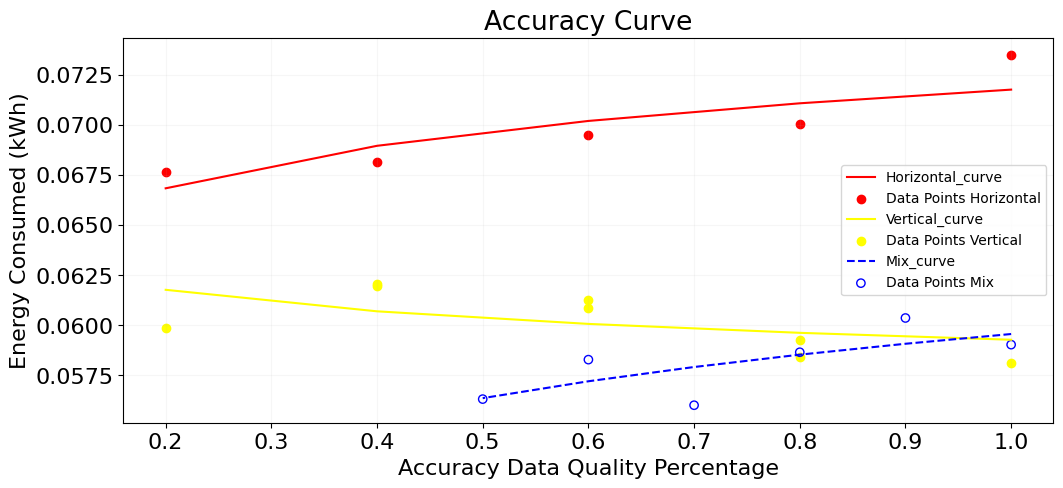

In [ ]:
#Curves Comparison Accuracy Horizontally and Vertical energy consumed
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/horizontal_accuracy.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/vertical_accuracy.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Accuracy/mix_accuracy.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["accuracy"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["accuracy"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["accuracy"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Accuracy Curve")
plt.xlabel("Accuracy Data Quality Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

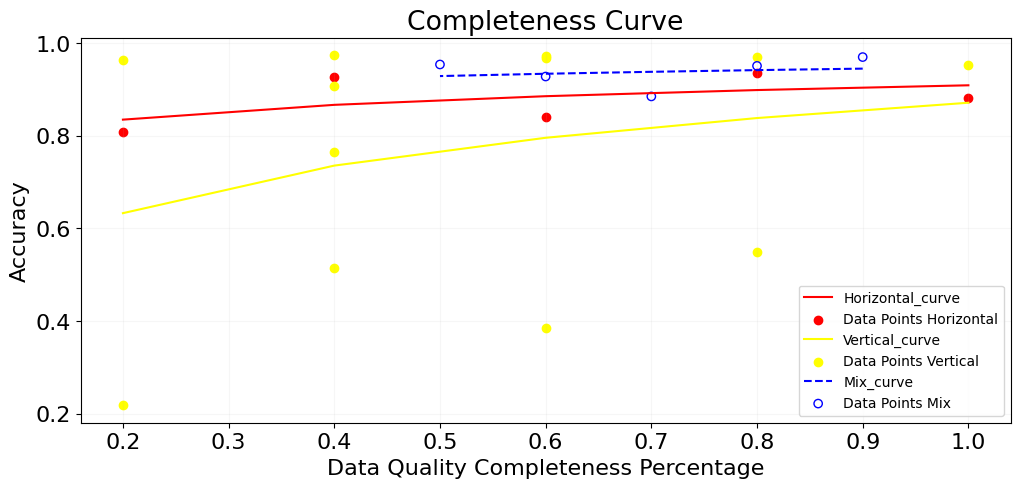

In [ ]:
#Curves Comparison Completeness Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/horizontal_completeness.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/vertical_completeness.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/mix_completeness.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["completeness"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["completeness"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["completeness"])


plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color="red", label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color="yellow", label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Completeness Curve")
plt.xlabel("Data Quality Completeness Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

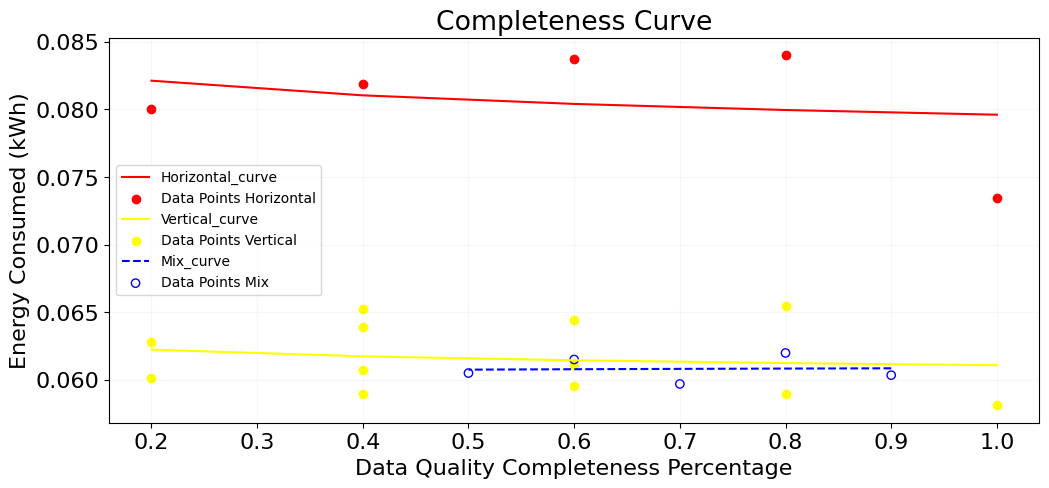

In [ ]:
#Curves Comparison Completeness Horizontally and Vertical energy consumption
file_path_h = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/horizontal_completeness.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/vertical_completeness.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Completeness/mix_completeness.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["completeness"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["completeness"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["completeness"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Completeness Curve")
plt.xlabel("Data Quality Completeness Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

## ChlorineConcentration

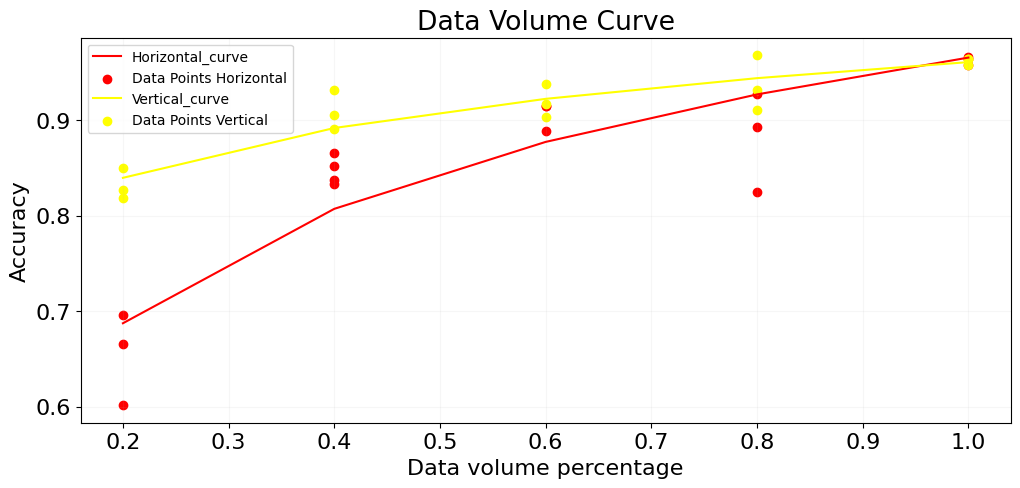

In [ ]:
#Curves Comparison Data Volume Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/horizontal_results.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/vertical_results.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["data_volume"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append((0.1*object_experiment["num_clients"]))

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.title("Data Volume Curve")
plt.xlabel("Data volume percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

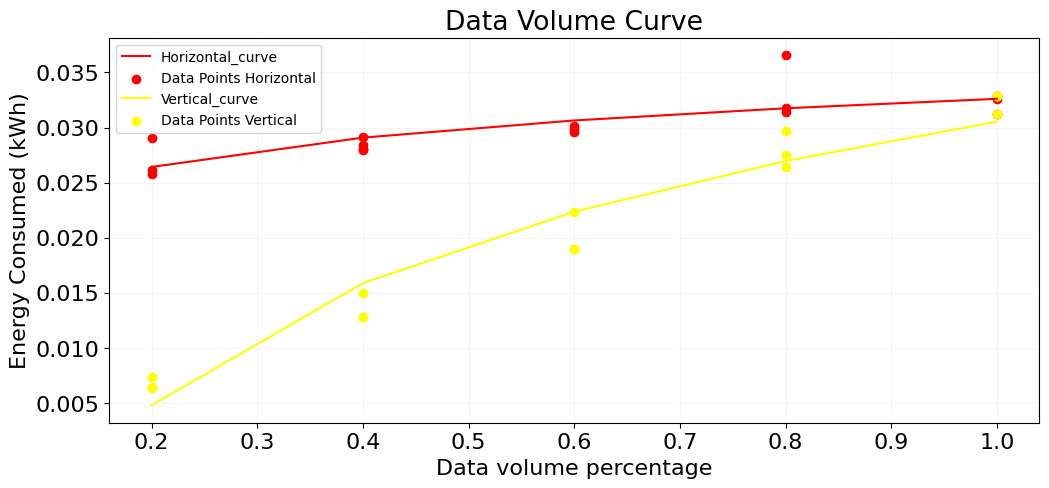

In [ ]:
#Curves Comparison Data Volume Horizontally and Vertical energy consumed
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/horizontal_results.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/vertical_results.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["data_volume"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append((0.1*object_experiment["num_clients"]))

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.title("Data Volume Curve")
plt.xlabel("Data volume percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

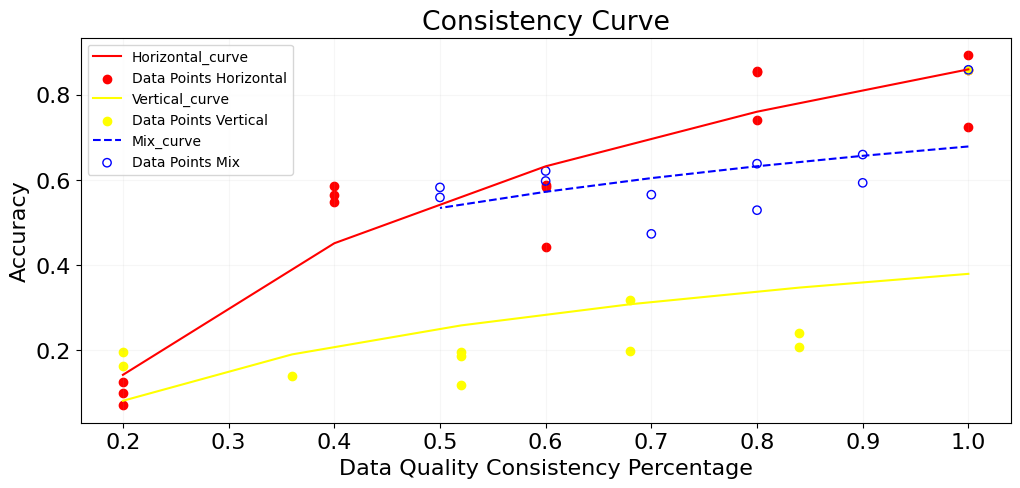

In [ ]:
#Curves Comparison Consistency Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/horizontal_consistency.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/vertical_consistency.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/mix_consistency.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["consistency"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["consistency"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["consistency"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Consistency Curve")
plt.xlabel("Data Quality Consistency Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

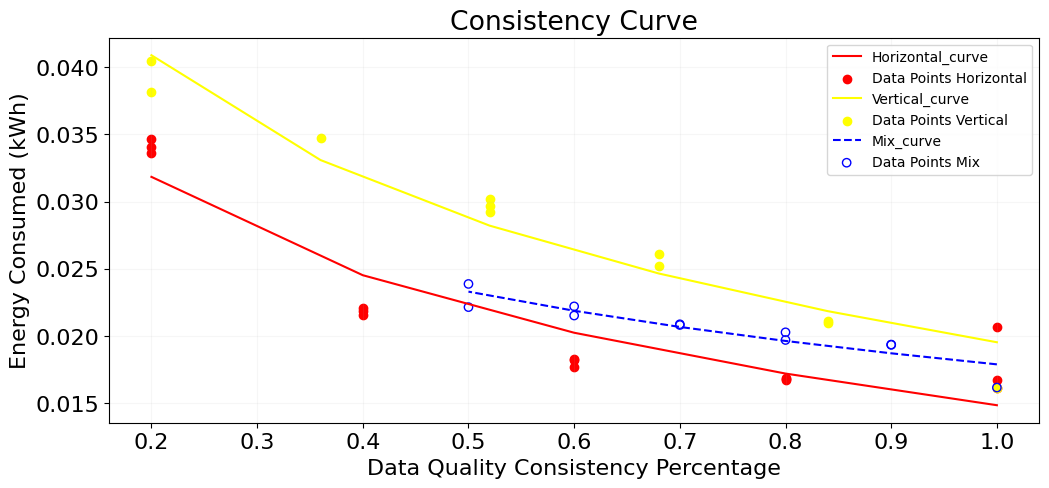

In [ ]:
#Curves Comparison Consistency Horizontally and Vertical energy consumed
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/horizontal_consistency.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/vertical_consistency.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Consistency/mix_consistency.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["consistency"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["consistency"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["consistency"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Consistency Curve")
plt.xlabel("Data Quality Consistency Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

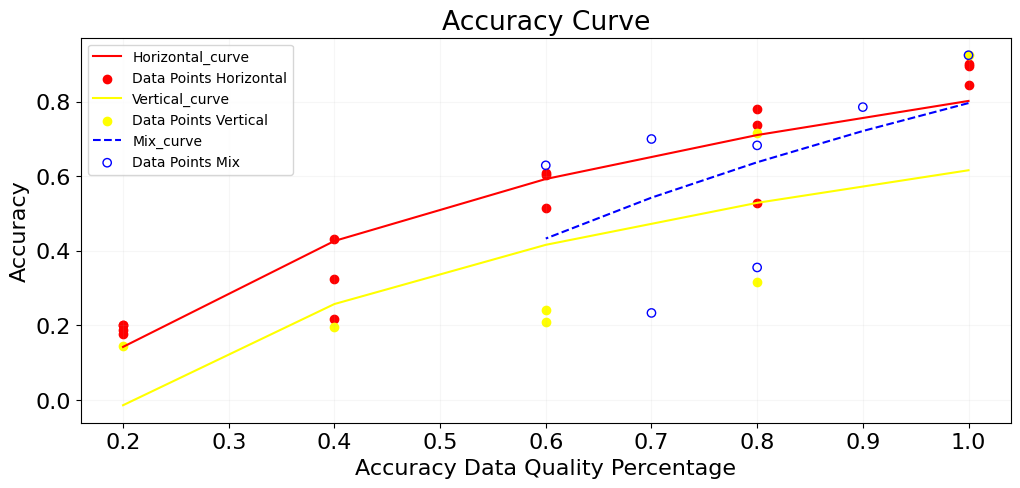

In [ ]:
#Curves Comparison Accuracy Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/horizontal_accuracy.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/vertical_accuracy.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/mix_accuracy.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["accuracy"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["accuracy"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["accuracy"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h,  color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Accuracy Curve")
plt.xlabel("Accuracy Data Quality Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

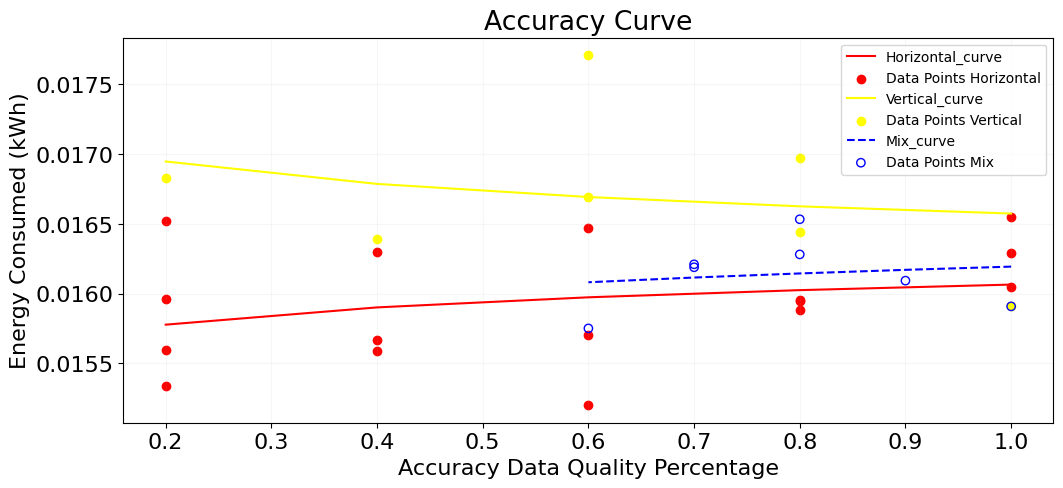

In [ ]:
#Curves Comparison Accuracy Horizontally and Vertical energy consumed
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/horizontal_accuracy.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/vertical_accuracy.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Accuracy/mix_accuracy.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["accuracy"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["accuracy"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["accuracy"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Accuracy Curve")
plt.xlabel("Accuracy Data Quality Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

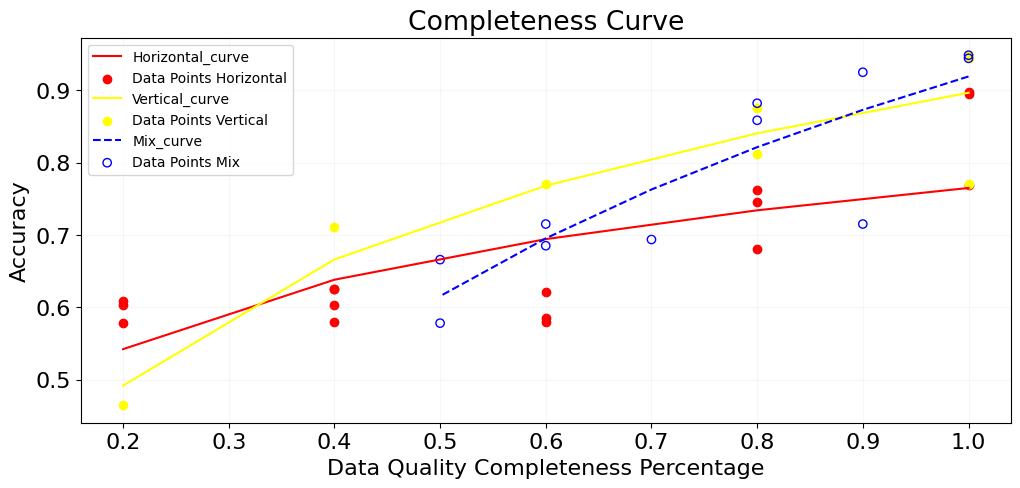

In [ ]:
#Curves Comparison Completeness Horizontally and Vertical performance
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/horizontal_completeness.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/vertical_completeness.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/mix_completeness.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["Accuracy_6"])
  x_values_h.append(object_experiment["completeness"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["Accuracy_6"])
  x_values_v.append(object_experiment["completeness"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["Accuracy_6"])
  x_values_m.append(object_experiment["completeness"])


plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color="red", label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color="yellow", label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Completeness Curve")
plt.xlabel("Data Quality Completeness Percentage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

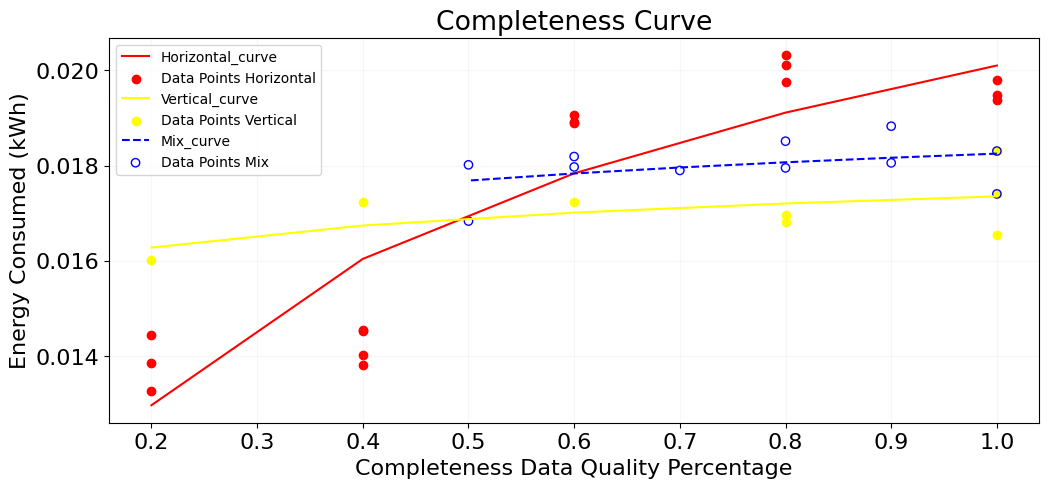

In [ ]:
#Curves Comparison Completeness Horizontally and Vertical energy consumption
file_path_h = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/horizontal_completeness.json'
with open(file_path_h, "r") as json_file:
    data_h = json.load(json_file)

file_path_v = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/vertical_completeness.json'
with open(file_path_v, "r") as json_file:
    data_v = json.load(json_file)

file_path_m = '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Completeness/mix_completeness.json'
with open(file_path_m, "r") as json_file:
    data_m = json.load(json_file)

x_values_h = []
y_values_h = []
for object_experiment in data_h:
  y_values_h.append(object_experiment["effective_energy_consumed"])
  x_values_h.append(object_experiment["completeness"])

x_values_v = []
y_values_v = []
for object_experiment in data_v:
  y_values_v.append(object_experiment["effective_energy_consumed"])
  x_values_v.append(object_experiment["completeness"])

x_values_m = []
y_values_m = []
for object_experiment in data_m:
  y_values_m.append(object_experiment["effective_energy_consumed"])
  x_values_m.append(object_experiment["completeness"])

plt.figure(figsize=(12,5))
plt.plot(x_values_h, create_curve(x_values_h, y_values_h), color='red', label='Horizontal_curve')
plt.scatter(x_values_h, y_values_h, color='red', label='Data Points Horizontal')
plt.plot(x_values_v, create_curve(x_values_v, y_values_v), color='yellow', label='Vertical_curve')
plt.scatter(x_values_v, y_values_v, color='yellow', label='Data Points Vertical')
plt.plot(x_values_m, create_curve(x_values_m, y_values_m), linestyle='--', color='blue', label='Mix_curve')
plt.scatter(x_values_m, y_values_m, marker='o', facecolors = 'none', edgecolors = 'blue', label='Data Points Mix')
plt.title("Completeness Curve")
plt.xlabel("Completeness Data Quality Percentage")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(alpha=0.1)
plt.legend(fontsize=10)
plt.show()

# Build Reduction Model

In [ ]:
def create_values(x_values_v, y_values_v):
  model = LinearRegression()
  x_values = np.array(x_values_v).reshape(-1, 1)
  model.fit(np.log(x_values), y_values_v)
  C1 = model.intercept_
  C2 = model.coef_[0]

  x_list = [round(0.1 * i, 1) for i in range(2, 11)] #To produce a list of values from 0.2 to 1.0
  values = C1 + C2 * np.log(x_list)

  return values

In [ ]:
def get_values(file_path):
  with open(file_path, "r") as json_file:
    data = json.load(json_file)

  x_values = []
  y_values = []
  if 'horizontal' in file_path:
    for object_experiment in data:
      y_values.append(object_experiment["Accuracy_6"])
      x_values.append(object_experiment["data_volume"])
  elif 'vertical' in file_path:
    for object_experiment in data:
      y_values.append(object_experiment["Accuracy_6"])
      x_values.append((0.1*object_experiment["num_clients"]))

  y_val = create_values(x_values, y_values) #It retrieves list of values from the curve
  return y_val

In [ ]:
def create_dataframe(file_path, meta_data, dataframe, extend):
  with open(file_path, "r") as json_file:
    data = json.load(json_file)

  for object_exp in data:
    first_meta = meta_data[:]
    items_to_append = [object_exp['Accuracy_6'], object_exp['num_clients'], object_exp['data_volume']]
    first_meta.extend(items_to_append)
    dataframe.loc[len(dataframe)] = first_meta

  if extend:
    values = get_values(file_path)
    volume = [i for i in range(2, 11)] # 2, 3, 4,...10
    print(volume)
    for object_val, q_volume in zip(values, volume):
      if object_val > 1.0:
        object_val = 0.99
      first_meta = meta_data[:]
      if 'horizontal' in file_path:
        items_to_append = [object_val, 10, round(0.1  *q_volume, 1)]
      if 'vertical' in file_path:
        items_to_append = [object_val, q_volume, 1.0]
      first_meta.extend(items_to_append)
      dataframe.loc[len(dataframe)] = first_meta

  return dataframe

In [ ]:
#Train a Random Forest Algorithm to define a model able to define the number of clients and the data volume per each client given a treashold accuracy value
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std


#Create a dataframe with named columns
columns = ['dataset_type', 'dataset_length', 'length_sequence', 't_model', 'num_param', 'tot_clients', 'accuracy', 'num_clients', 'data_volume']
dataframe = pd.DataFrame(columns=columns)

#Info about ChlorineConcentration
data_chlo = ['Sensor', 3740, 166, 'Resnet', model_info.count_params(), 10]
data_star = ['Sensor', 7236, 1024, 'Resnet', model_info.count_params(), 10]

files = ['/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/horizontal_results.json', '/gdrive/My Drive/Tesi Notebooks/ChlorineConcentration/results/Data Volume/vertical_results.json', '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_horizontal.json', '/gdrive/My Drive/Tesi Notebooks/StarLightCurves/results/Data Volume/results_vertical.json']

for file_path in files:
  if 'ChlorineConcentration' in file_path:
    dataframe = create_dataframe(file_path, data_chlo, dataframe, True)
  elif 'StarLightCurves' in file_path:
    dataframe = create_dataframe(file_path, data_star, dataframe, True)


target_columns = columns[-2:]
input_feature = columns[:-2]
X_train_dataframe = dataframe.drop(columns=target_columns)
Y_train_dataframe = dataframe.drop(columns=input_feature)

categorical_columns = ['dataset_type', 't_model']
X_train_dataframe = pd.get_dummies(X_train_dataframe, columns=categorical_columns, prefix=categorical_columns)

X_training, X_testing, Y_training, Y_testing = train_test_split(X_train_dataframe, Y_train_dataframe, test_size=0.1, random_state=42)

#Define the models
model = DecisionTreeRegressor()
model.fit(X_training, Y_training)
print("MSE DecisionTreeRegressor: %.3f" % mean_squared_error(Y_testing, model.predict(X_testing)))

model = DecisionTreeRegressor()
model.fit(X_training, Y_training)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_training, Y_training, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
n_scores = absolute(n_scores)
# summarize performance
print('Kfold Cross Validation DecisionTree MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model = RandomForestRegressor()
model.fit(X_training, Y_training)
print("MSE RandomForestRegressor: %.3f" % mean_squared_error(Y_testing, model.predict(X_testing)))

model = RandomForestRegressor()
model.fit(X_training, Y_training)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_training, Y_training, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
n_scores = absolute(n_scores)
# summarize performance
print('Kfold Cross Validation RandomForest MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model = LinearSVR()
wrapper = RegressorChain(model)
wrapper.fit(X_training, Y_training)
print('RegressionChain SVR MSE: %.3f' % mean_squared_error(Y_testing, wrapper.predict(X_testing)))

[0.68746788 0.75749116 0.80717346 0.84571005 0.87719673 0.90381834
 0.92687903 0.94722    0.96541562]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.83961857 0.87011467 0.89175199 0.90853521 0.92224809 0.93384217
 0.94388542 0.95274419 0.96066863]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.51985334 0.6507655  0.74364916 0.81569533 0.87456133 0.92433183
 0.96744499 1.0054735  1.03949116]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.89647501 0.91375192 0.92601008 0.93551825 0.943287   0.94985537
 0.95554516 0.96056391 0.96505333]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
MSE DecisionTreeRegressor: 5.174
Kfold Cross Validation DecisionTree MSE: 6.921 (4.076)
MSE RandomForestRegressor: 4.330
Kfold Cross Validation RandomForest MSE: 4.819 (2.863)
RegressionChain SVR MSE: 1.651


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
